### Top 10 Algorithms for Binary Classification 

1. Naive Bayes
2. Logistic Regression
3. K-Nearest Neighbours
4. Support Vector Machine
5. Decision Tree 
6. Bagging  Decision Tree (Ensemble Learning I)
7. Boosted Decision Tree (Ensemble Learning II)
8. Random Forest (Ensemble Learning III)
9. Voting Classification (Ensemble Learning IV)
10. Deep Learning with a neuronal network

https://github.com/alexortner/teaching/blob/master/binary_classification/Top_10_Binary_Classification_BreastCancer.ipynb

***Comparaciones de bootstrap***
* 1	Aproximación normal	95,6%
* 2.1	Bootstrap, IC de 1 muestra	98,5%
* 2.2	Bootstrap, percentil	98,0%
* 2.3	Arranque, .632	83,2%
* 3	Conjunto de prueba de arranque	94,5%

Tanto la aproximación normal (método 1) como el arranque de los conjuntos de prueba (método 3) son opciones prácticas y precisas. Cuando se trata explícitamente de modelos de aprendizaje profundo, considerar diferentes semillas aleatorias (método 4) es otra técnica que vale la pena considerar. Tenga en cuenta que los métodos 1 y 2 son convenientes, ya que no requieren entrenar varios modelos, a diferencia del método 4. Sin embargo, el método 4 puede ser atractivo para las comparaciones de algoritmos, ya que también nos dice qué tan dependiente es un algoritmo de la semilla aleatoria. 

* Cuando el modelo nos da diferencias variables y grandes entre predicciones y observaciones (es un método que sufre de varianza), y al sufrir varianza genera sobreAjuste u overfitting.
* Generalmente cuando reducimos la varianza (usando métodos más rígidos), nos arriesgamos a sufrir más sesgo.
* método sufre (ajuste lineal) de sesgo: es un método rígido que no aprende de patrones en los datos. Predicción pobre o baja precisión.

Un split 70%-30% de mis datos tengo una predicción no sobreajustada únicamente sobre el 30% de mis datos (el otro 70% es un conjunto donde potencialmente sobreajusté el modelo).
Una forma de atenuar estos problemas es usar validación cruzada estratificada con K folds.
¿Qué features incluir?
Select K-best: obtengo una medida de qué tan diferente es el feature entre las dos clases  (por defecto, ANOVA F-score) y luego me quedo con los K features que tienen máximo score.

** Intervalos de confianza **
- Muchos artículos de investigación que adoptaron este estándar mínimo sugerido al incluir estimaciones de incertidumbre. 

 Los intervalos de confianza son una forma de hacerlo. Sin embargo, también es útil incluir el rendimiento promedio en diferentes divisiones de conjuntos de datos o semillas aleatorias con la varianza o la desviación estándar; este enfoque más simple es más sencillo de explicar.
 Tenemos una estadística como la media de una muestra que calculamos a partir de una muestra extraída de una población desconocida. Nuestro objetivo es estimar un parámetro poblacional con esta estadística; por ejemplo, podríamos estimar la media poblacional utilizando la media muestral. Sin embargo, la mayoría de las veces, los valores estimados y reales no son exactamente iguales. Aquí, podemos usar el intervalo de confianza para cuantificar la incertidumbre de esa estimación.

 - Como nota al margen, podemos decir que la diferencia de dos mediciones es estadísticamente significativa si los intervalos de confianza no se superponen. Sin embargo, no podemos decir que los resultados no sean estadísticamente significativos si los intervalos de confianza se superponen. Esto se debe a que los intervalos de confianza son solo una estimación de la incertidumbre de la estimación. Por lo tanto, si los intervalos de confianza se superponen, no podemos concluir que las estimaciones no sean estadísticamente significativas. En cambio, necesitamos realizar una prueba de hipótesis para determinar si las estimaciones son estadísticamente significativas.
 - Si queremos comprobar si la diferencia no es estadísticamente significativa, tendríamos que echar un vistazo a la distribución de las diferencias que queremos comparar y comprobar si su intervalo de confianza contiene 0 o no.

Es una convención común usar un intervalo de confianza del 95% en la práctica, pero ¿cómo lo interpretamos? Primero, supongamos que tenemos acceso a la población. (Por supuesto, este nunca es el caso. De lo contrario, no tendríamos que estimar un parámetro pero podríamos calcularlo con precisión). Entonces, si extraemos una gran cantidad de muestras de la distribución y aplicamos nuestro método de intervalo de confianza a estas muestras, el 95% de los intervalos de confianza contendrían el valor real. En otras palabras, el 95% de las veces, nuestro intervalo de confianza contendría el valor real. Por lo tanto, podemos decir que estamos 95% seguros de que el intervalo de confianza contiene el valor real.

En un contexto de aprendizaje automático ML, lo que nos suele interesar es el rendimiento de nuestro modelo. Entonces, aquí el parámetro de población que queremos estimar podría ser la precisión de generalización de nuestro modelo. Luego, la precisión del conjunto de prueba representa nuestra precisión de generalización estimada. Finalmente, el intervalo de confianza del 95% nos da una medida de incertidumbre de qué tan precisa es esta estimación.


Tanto la aproximación normal (método 1 - **normal approximation** -) como el arranque de los conjuntos de prueba (método 3 - **bootstrapping the test sets**-) son opciones prácticas y precisas. Cuando se trata explícitamente de modelos de aprendizaje profundo, considerar diferentes semillas aleatorias (método 4 - **random seeds** -) es otra técnica que vale la pena considerar. Tenga en cuenta que los métodos 1 y 2 son convenientes, ya que no requieren entrenar varios modelos, a diferencia del método 4. Sin embargo, el método 4 puede ser atractivo para las comparaciones de algoritmos, ya que también nos dice qué tan dependiente es un algoritmo de la semilla aleatoria.



In [17]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline

In [18]:
# Estandarizador (transforma las variables en z-scores)
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score, mean_squared_error, ConfusionMatrixDisplay # Accuracy metrics 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from scikitplot.metrics import plot_roc


In [19]:
import utils as ut
import pickle
# Indicamos que los tipos de datos float se muestren con 2 decimales
pd.options.display.float_format = '{:.2f}'.format

In [23]:
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

In [286]:
df = load_data_prep()

In [287]:
df1 = df[[ 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length',
 'sl2l_volume', 'tral_volume','label']]
df1.shape

(96, 7)

In [288]:
# Partición en train y test
y = df1.loc[:, df1.columns == 'label']
X = df1.loc[:, df1.columns != 'label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [289]:
X_= X_train.reset_index()
y_= y_train.reset_index()
X_=X_.drop('index', axis=1)
y_=y_.drop('index', axis=1)

In [290]:
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente
minmx_scale = MinMaxScaler()

In [291]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression # sci-kit learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold


In [292]:
pipelines = {
    'mnb':make_pipeline(MinMaxScaler(), MultinomialNB()),
    'lr':make_pipeline(StandardScaler(), LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)),
    'knn':make_pipeline(StandardScaler(), KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)),
    'svm':make_pipeline(StandardScaler(), LinearSVC(C=0.0001)),
    'clf':make_pipeline(StandardScaler(), DecisionTreeClassifier(min_samples_split=10,max_depth=3)),
    'bglr':make_pipeline(StandardScaler(), BaggingClassifier(LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True),max_samples=0.5,max_features=1.0,n_estimators=10)),
    'bg':make_pipeline(StandardScaler(), BaggingClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=3),max_samples=0.5,max_features=1.0,n_estimators=10)),
    'adb':make_pipeline(StandardScaler(), AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=100,learning_rate=0.5)),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 100, n_jobs = -1, oob_score = True, bootstrap = True, random_state=42, max_depth=3)),
    'evc':make_pipeline(MinMaxScaler(), VotingClassifier(estimators=[('mnb',MultinomialNB()),('lr', LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)),('rf',RandomForestClassifier(n_estimators=300,max_depth=3)),('svm',LinearSVC(C=0.0001))]))}


In [293]:
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X_, y_) # arma los folds a partir de los datos

# acc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# pr_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# rc_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
# indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
fit_models = {}

for algo, pipeline in pipelines.items():
      acc_values = []
      pr_sc_values = [] 
      rc_sc_values = []
      for train_index, test_index in skf.split(X_, y_): # va generando los indices que corresponden a train y test en cada fold
            X_train_, X_test_ = X_.iloc[train_index], X_.iloc[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
            y_train_, y_test_ = y_.iloc[train_index], y_.iloc[test_index]     # idem con los targets
            
            #scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            #scaler.fit(X_train_) # encuentro los parametros para el escaleo
            #X_train_ = scaler.transform(X_train_) # aplico la transformacion

            #scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            #scaler.fit(X_test_) # encuentro los parametros para el escaleo
            #X_test_ = scaler.transform(X_test_) # aplico la transformacion
            
            model = pipeline.fit(X_train_, np.ravel(y_train_))
            probas_test = model.predict(X_test_)  # probabilidades con datos de evaluación
            
            acc_test = accuracy_score(y_test_, probas_test)
            pr_sc = precision_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            rc_sc = recall_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            
            acc_values.append(acc_test)
            pr_sc_values.append(pr_sc)
            rc_sc_values.append(rc_sc)
            
            print(algo,'ac-sc: {}'.format(round(accuracy_score(y_test_, probas_test),3)),
                  'pr-sc: {}'.format(round(precision_score(y_test_.values, probas_test, average="weighted", pos_label="arriba"),3)),
                  'rc-sc: {}'.format(round(recall_score(y_test_.values, probas_test, average="weighted", pos_label="arriba"),3)))
      fit_models[algo] = model
            
      print('----------------------------------------------------')
      print('--------------PROMEDIOS--DE--',algo,'-------------------------')
      print('Accuracy {}'.format(round(np.mean(acc_values),3)), 
      'precision_score {}'.format(round(np.mean(pr_sc_values),3)),
      'recall_score {}'.format(round(np.mean(rc_sc_values),3)))
      print('----------------------------------------------------')
      print('----------------------------------------------------')
      # fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
      # auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

      # auc_values.append(auc_test)
      # scores = np.concatenate((scores,probas_test[:,1]),axis=0)
      # indices = np.concatenate((indices,test_index),axis=0)
      fit_models[algo] = model

mnb ac-sc: 0.875 pr-sc: 0.9 rc-sc: 0.875
mnb ac-sc: 0.667 pr-sc: 0.806 rc-sc: 0.667
mnb ac-sc: 0.8 pr-sc: 0.86 rc-sc: 0.8
mnb ac-sc: 0.533 pr-sc: 0.553 rc-sc: 0.533
mnb ac-sc: 0.733 pr-sc: 0.83 rc-sc: 0.733
----------------------------------------------------
--------------PROMEDIOS--DE-- mnb -------------------------
Accuracy 0.722 precision_score 0.79 recall_score 0.722
----------------------------------------------------
----------------------------------------------------
lr ac-sc: 0.75 pr-sc: 0.767 rc-sc: 0.75
lr ac-sc: 0.733 pr-sc: 0.733 rc-sc: 0.733
lr ac-sc: 0.733 pr-sc: 0.747 rc-sc: 0.733
lr ac-sc: 0.733 pr-sc: 0.733 rc-sc: 0.733
lr ac-sc: 0.667 pr-sc: 0.673 rc-sc: 0.667
----------------------------------------------------
--------------PROMEDIOS--DE-- lr -------------------------
Accuracy 0.723 precision_score 0.731 recall_score 0.723
----------------------------------------------------
----------------------------------------------------
knn ac-sc: 0.688 pr-sc: 0.69 rc-sc: 0

In [32]:
# Ajustamos el estandarizador
std_scale.fit(X_test)
std_scale.fit(X_train)
minmx_scale.fit(X_test)
minmx_scale.fit(X_train)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)
X_scaled = std_scale.transform(X_train)
X_test_norm =  minmx_scale.transform(X_test)
X_norm = minmx_scale.transform(X_train)

### 1. Naive Bayes

In [33]:
from sklearn.naive_bayes import MultinomialNB

In [34]:
y_predicted = fit_models['mnb'].predict_proba(X_test)

In [35]:
# mnb = MultinomialNB().fit(X_norm, y_train)

In [36]:
print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['mnb'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['mnb'].score(X_train, y_train)))

train shape: (76, 6)
score on test: 0.85
score on train: 0.7368421052631579


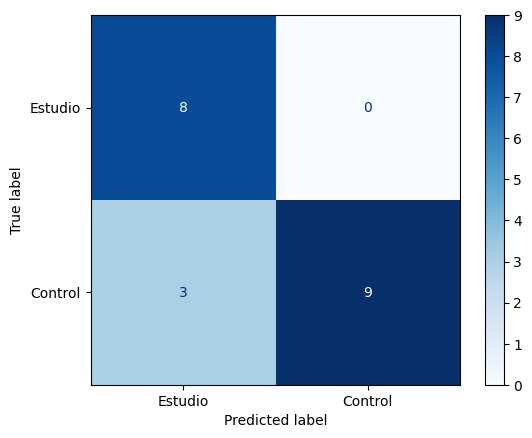

In [37]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['mnb'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [38]:
print(classification_report(y_true=y_test,y_pred=fit_models['mnb'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.75      0.86        12

    accuracy                           0.85        20
   macro avg       0.86      0.88      0.85        20
weighted avg       0.89      0.85      0.85        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

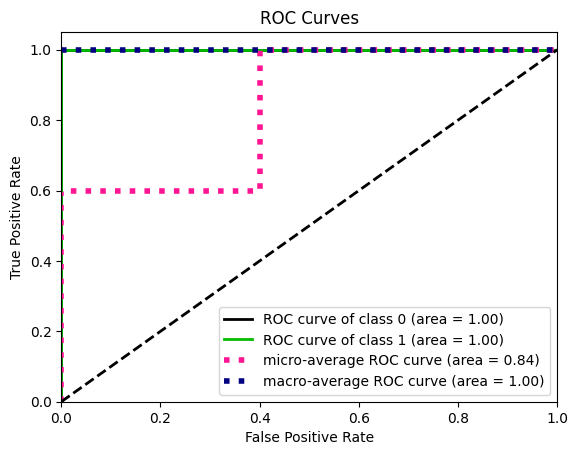

In [39]:
y_predicted_mnb = fit_models['mnb'].predict_proba(X_test_norm)
plot_roc(y_test, y_predicted_mnb)

In [40]:
y_= y_train.label.values
mnb_ = MultinomialNB()
mnb_result = cross_validation(mnb_, X_norm.tolist(), y_.tolist(), 5)
mnb_result

{'Training Accuracy scores': array([0.75      , 0.75409836, 0.73770492, 0.68852459, 0.70491803]),
 'Mean Training Accuracy': 72.70491803278689,
 'Training Precision scores': array([0.74193548, 0.7       , 0.69230769, 0.76190476, 0.83333333]),
 'Mean Training Precision': 0.745896254283351,
 'Training Recall scores': array([0.76666667, 0.90322581, 0.87096774, 0.53333333, 0.5       ]),
 'Mean Training Recall': 0.7148387096774194,
 'Training F1 scores': array([0.75409836, 0.78873239, 0.77142857, 0.62745098, 0.625     ]),
 'Mean Training F1 Score': 0.7133420613685326,
 'Validation Accuracy scores': array([0.6875    , 0.53333333, 0.53333333, 0.73333333, 0.6       ]),
 'Mean Validation Accuracy': 61.74999999999999,
 'Validation Precision scores': array([0.71428571, 0.5       , 0.5       , 1.        , 0.66666667]),
 'Mean Validation Precision': 0.6761904761904762,
 'Validation Recall scores': array([0.625     , 0.71428571, 0.85714286, 0.5       , 0.5       ]),
 'Mean Validation Recall': 0.6392

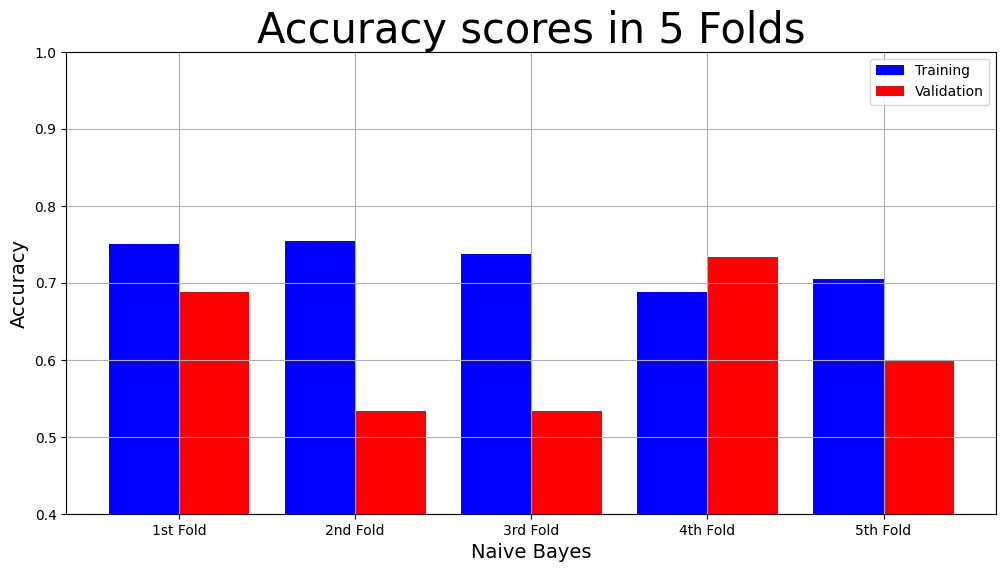

In [41]:
model_name = "Naive Bayes"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            mnb_result["Training Accuracy scores"],
            mnb_result["Validation Accuracy scores"])

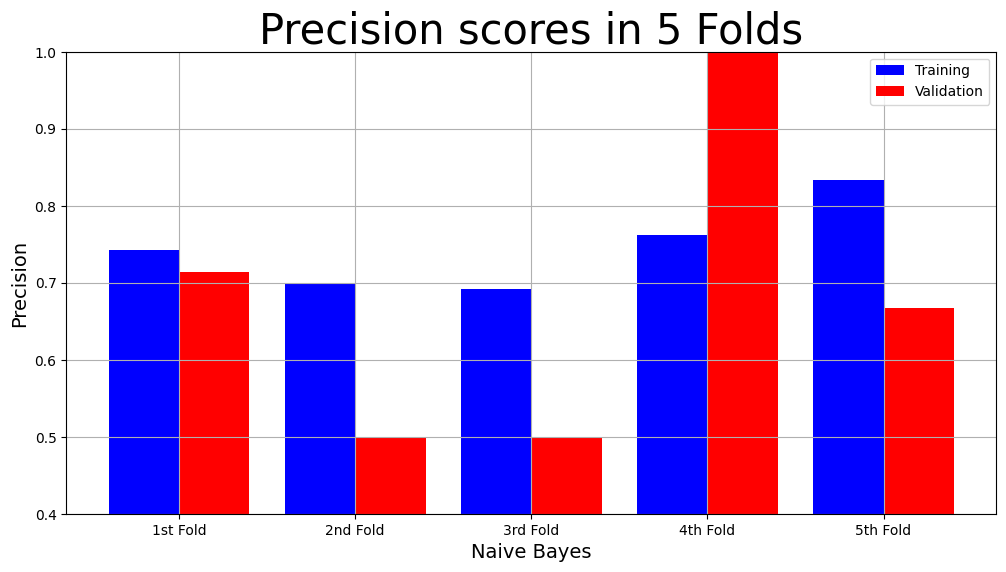

In [42]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            mnb_result["Training Precision scores"],
            mnb_result["Validation Precision scores"])

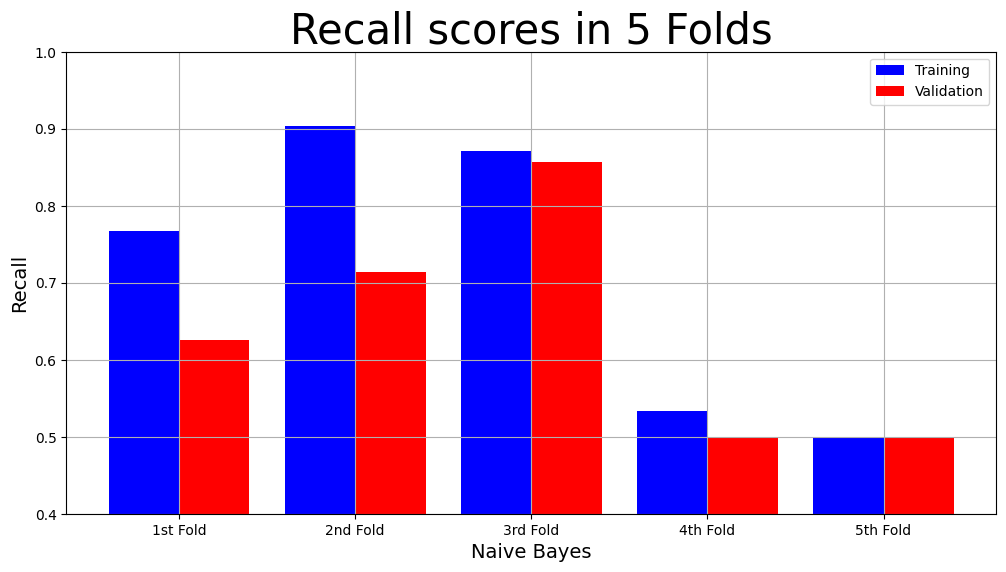

In [43]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            mnb_result["Training Recall scores"],
            mnb_result["Validation Recall scores"])

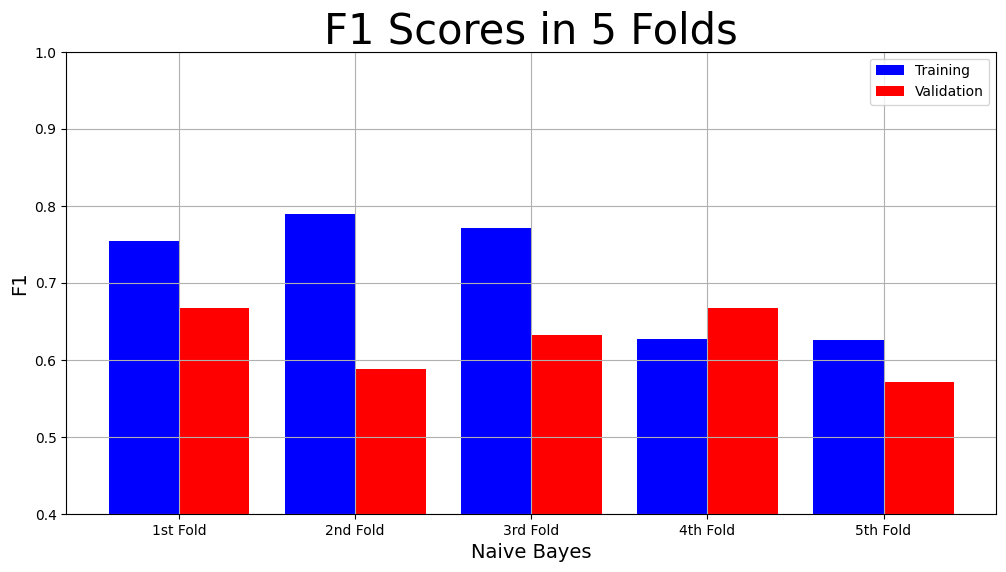

In [44]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            mnb_result["Training F1 scores"],
            mnb_result["Validation F1 scores"])

### 2. Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression # sci-kit learn

In [46]:
# lr = LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)
# lr.fit(X_scaled, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['lr'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['lr'].score(X_train, y_train)))

train shape: (76, 6)
score on test: 0.95
score on train: 0.7631578947368421


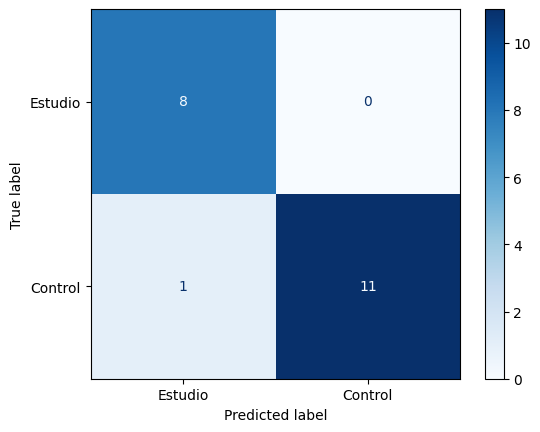

In [47]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['lr'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [48]:
print(classification_report(y_true=y_test,y_pred=fit_models['lr'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.92      0.96        12

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

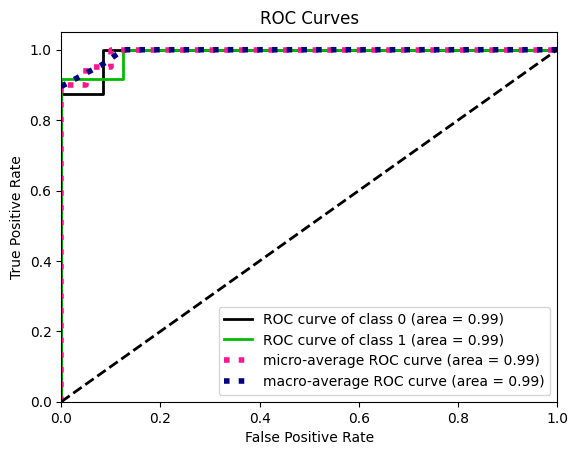

In [49]:
y_predicted = fit_models['lr'].predict_proba(X_test)
plot_roc(y_test, y_predicted)

In [50]:
lr = LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)
lr_result = cross_validation(lr, X_scaled, y_train, 5)
lr_result

{'Training Accuracy scores': array([0.71666667, 0.78688525, 0.73770492, 0.75409836, 0.7704918 ]),
 'Mean Training Accuracy': 75.31693989071039,
 'Training Precision scores': array([0.70967742, 0.78125   , 0.74193548, 0.77777778, 0.78571429]),
 'Mean Training Precision': 0.759270993343574,
 'Training Recall scores': array([0.73333333, 0.80645161, 0.74193548, 0.7       , 0.73333333]),
 'Mean Training Recall': 0.743010752688172,
 'Training F1 scores': array([0.72131148, 0.79365079, 0.74193548, 0.73684211, 0.75862069]),
 'Mean Training F1 Score': 0.7504721095699856,
 'Validation Accuracy scores': array([0.8125    , 0.4       , 0.86666667, 0.8       , 0.53333333]),
 'Mean Validation Accuracy': 68.24999999999999,
 'Validation Precision scores': array([0.85714286, 0.375     , 0.85714286, 1.        , 0.6       ]),
 'Mean Validation Precision': 0.7378571428571429,
 'Validation Recall scores': array([0.75      , 0.42857143, 0.85714286, 0.625     , 0.375     ]),
 'Mean Validation Recall': 0.60714

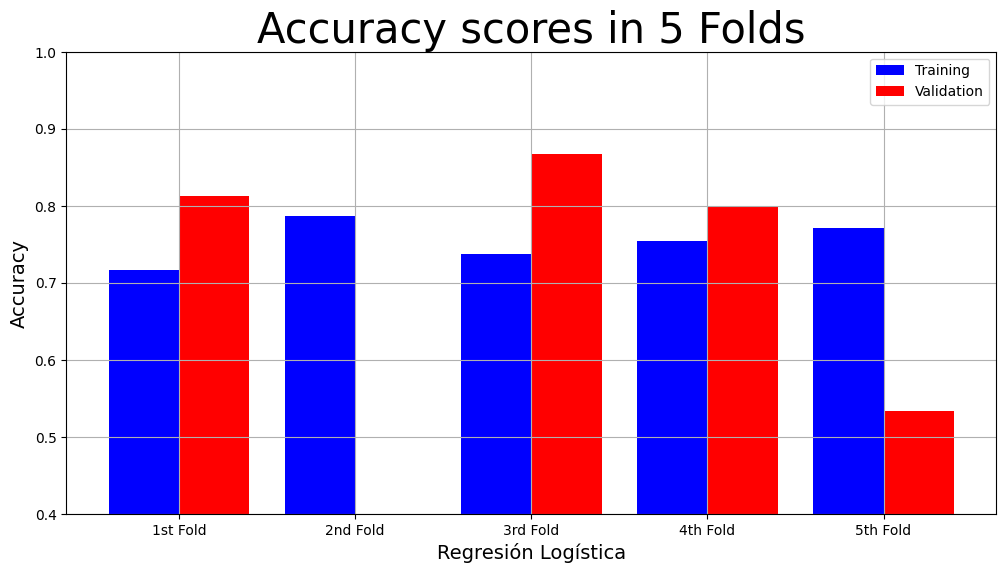

In [51]:
model_name = "Regresión Logística"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            lr_result["Training Accuracy scores"],
            lr_result["Validation Accuracy scores"])

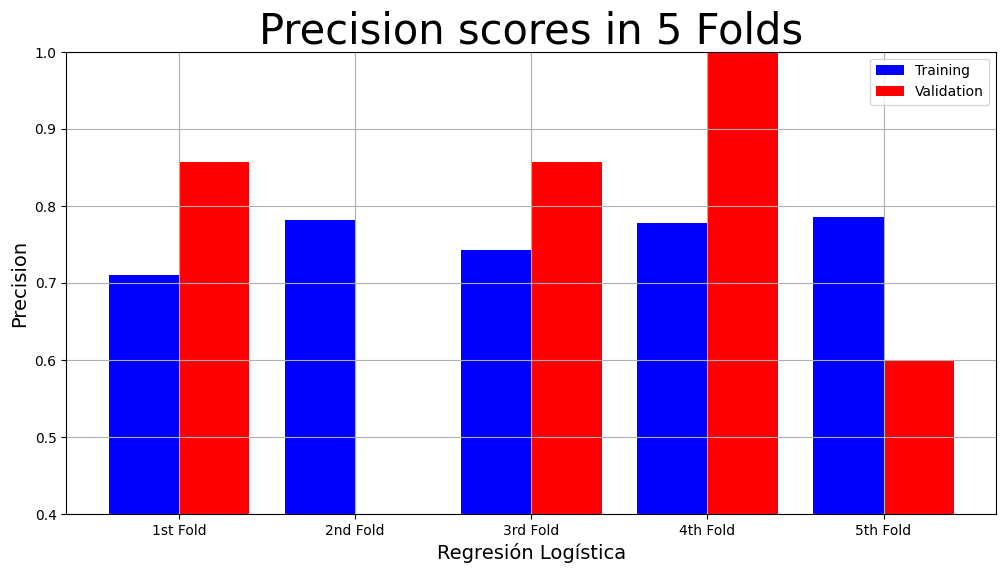

In [52]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            lr_result["Training Precision scores"],
            lr_result["Validation Precision scores"])

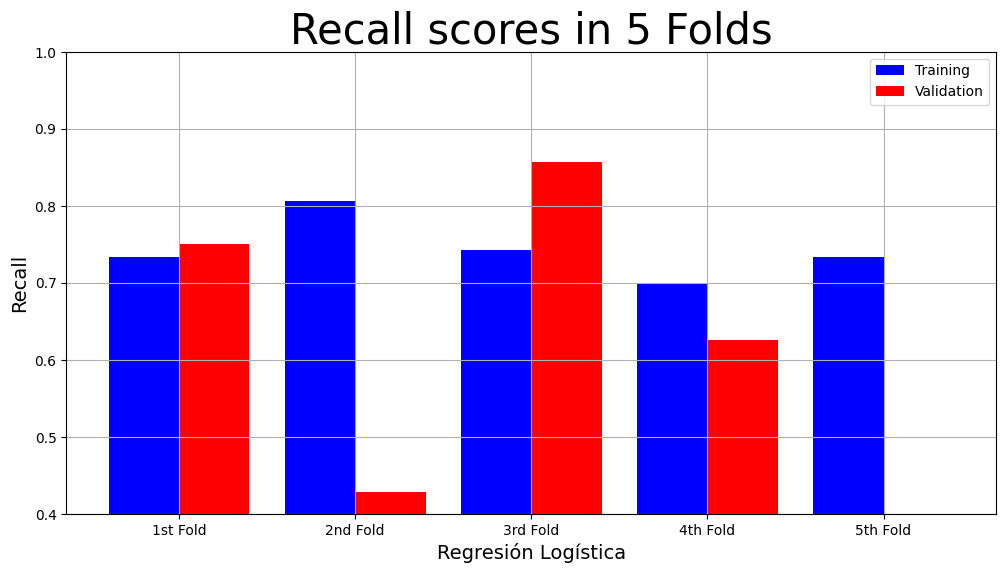

In [53]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            lr_result["Training Recall scores"],
            lr_result["Validation Recall scores"])

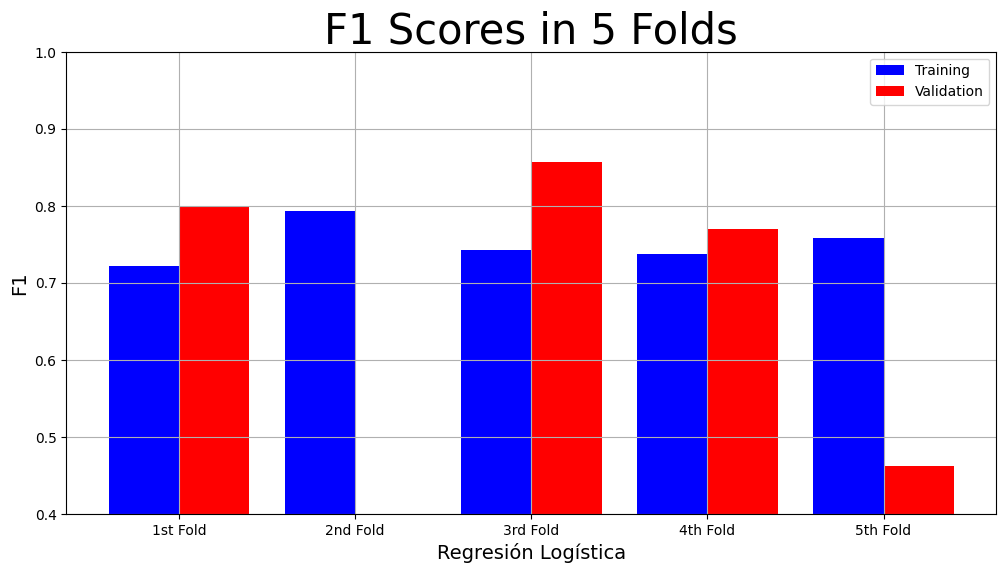

In [54]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            lr_result["Training F1 scores"],
            lr_result["Validation F1 scores"])

### 3. K-Nearest Neighbours

In [55]:
%%time

from sklearn.neighbors import KNeighborsClassifier

#knn = KNeighborsClassifier(n_neighbors=5,algorithm = 'ball_tree')
## knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)

# knn.fit(X_scaled, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['knn'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['knn'].score(X_train, y_train)))

train shape: (76, 6)
score on test: 0.95
score on train: 0.75
CPU times: total: 15.6 ms
Wall time: 21.1 ms


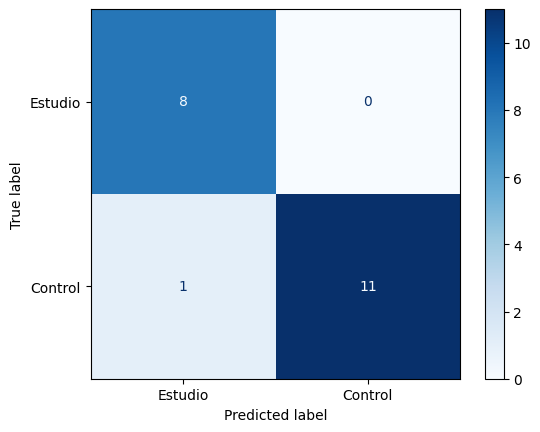

In [56]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['knn'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [57]:
print(classification_report(y_true=y_test,y_pred=fit_models['knn'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.92      0.96        12

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

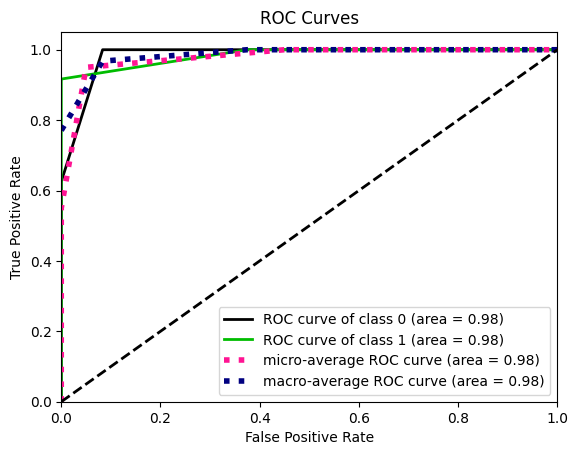

In [58]:
y_predicted = fit_models['knn'].predict_proba(X_test)
plot_roc(y_test, y_predicted)

In [59]:
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn_result = cross_validation(knn, X_scaled, y_train, 5)
knn_result

{'Training Accuracy scores': array([0.78333333, 0.78688525, 0.78688525, 0.80327869, 0.85245902]),
 'Mean Training Accuracy': 80.25683060109289,
 'Training Precision scores': array([0.79310345, 0.78125   , 0.73684211, 0.78125   , 0.81818182]),
 'Mean Training Precision': 0.7821254743441677,
 'Training Recall scores': array([0.76666667, 0.80645161, 0.90322581, 0.83333333, 0.9       ]),
 'Mean Training Recall': 0.8419354838709678,
 'Training F1 scores': array([0.77966102, 0.79365079, 0.8115942 , 0.80645161, 0.85714286]),
 'Mean Training F1 Score': 0.8097000967089161,
 'Validation Accuracy scores': array([0.625     , 0.46666667, 0.53333333, 0.66666667, 0.66666667]),
 'Mean Validation Accuracy': 59.16666666666666,
 'Validation Precision scores': array([0.58333333, 0.33333333, 0.5       , 0.71428571, 0.71428571]),
 'Mean Validation Precision': 0.569047619047619,
 'Validation Recall scores': array([0.875     , 0.14285714, 0.57142857, 0.625     , 0.625     ]),
 'Mean Validation Recall': 0.5678

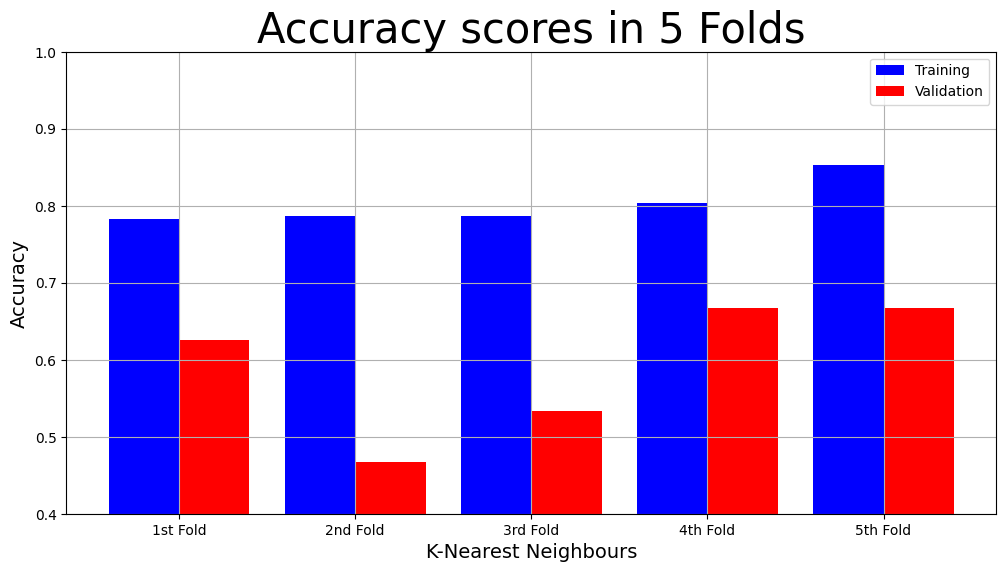

In [60]:
model_name = "K-Nearest Neighbours"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            knn_result["Training Accuracy scores"],
            knn_result["Validation Accuracy scores"])

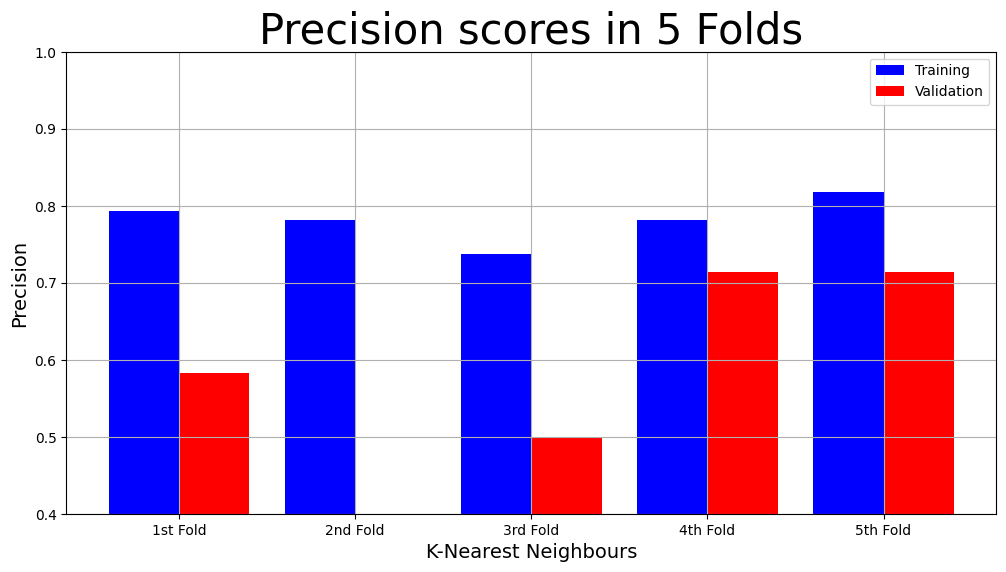

In [61]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            knn_result["Training Precision scores"],
            knn_result["Validation Precision scores"])

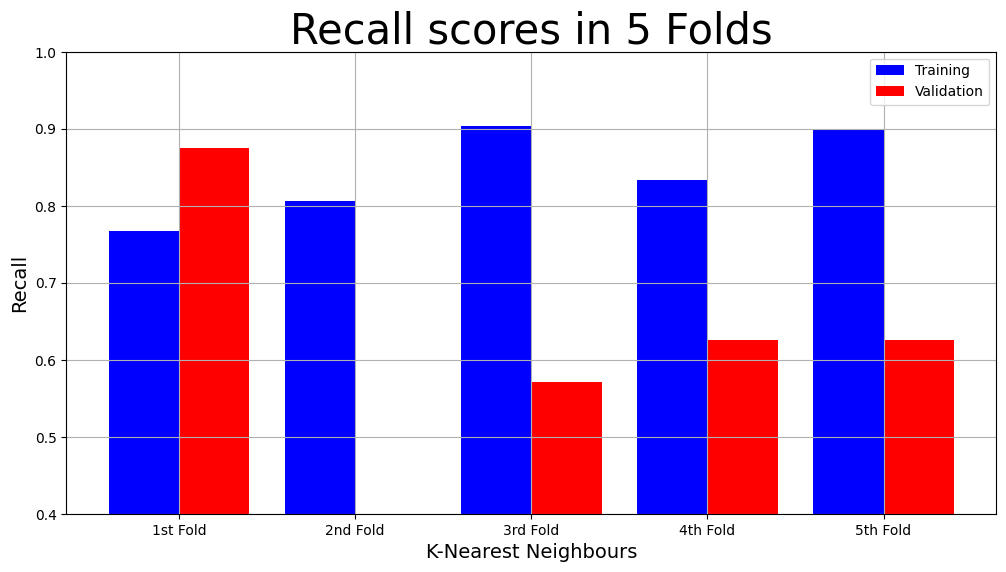

In [62]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            knn_result["Training Recall scores"],
            knn_result["Validation Recall scores"])

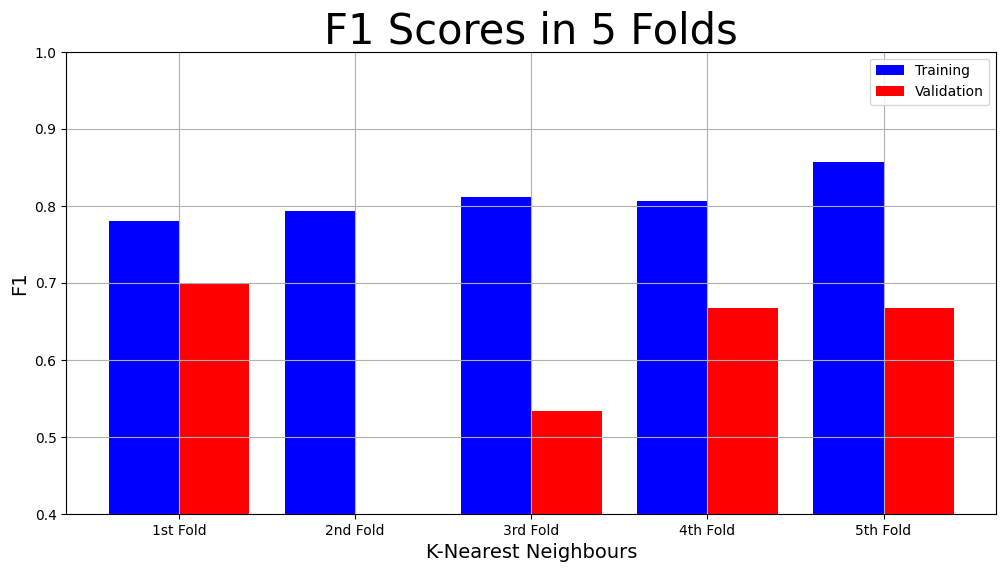

In [63]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            knn_result["Training F1 scores"],
            knn_result["Validation F1 scores"])

### 4. Support Vector Machine

In [64]:
%%time

from sklearn.svm import LinearSVC

#svm=LinearSVC(C=0.0001)
#svm.fit(X_scaled, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['svm'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['svm'].score(X_train, y_train)))

train shape: (76, 6)
score on test: 0.95
score on train: 0.7105263157894737
CPU times: total: 0 ns
Wall time: 12.4 ms


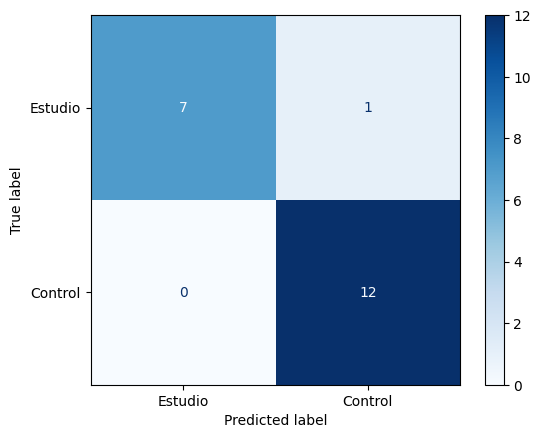

In [65]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['svm'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [66]:
print(classification_report(y_true=y_test,y_pred=fit_models['svm'].predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.92      1.00      0.96        12

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20



In [67]:
#y_predicted = svm._predict_proba_lr(X_test_scaled)
#y_predicted = fit_models['svm']._predict_proba_lr(X_test)
#plot_roc(y_test, y_predicted)

In [68]:
svm=LinearSVC(C=0.0001)
svm_result = cross_validation(svm, X_scaled, y_train, 5)
svm_result

{'Training Accuracy scores': array([0.71666667, 0.73770492, 0.70491803, 0.68852459, 0.78688525]),
 'Mean Training Accuracy': 72.69398907103825,
 'Training Precision scores': array([0.68571429, 0.72727273, 0.70967742, 0.68965517, 0.84      ]),
 'Mean Training Precision': 0.7304639209511289,
 'Training Recall scores': array([0.8       , 0.77419355, 0.70967742, 0.66666667, 0.7       ]),
 'Mean Training Recall': 0.7301075268817204,
 'Training F1 scores': array([0.73846154, 0.75      , 0.70967742, 0.6779661 , 0.76363636]),
 'Mean Training F1 Score': 0.7279482846295313,
 'Validation Accuracy scores': array([0.8125    , 0.4       , 0.66666667, 0.8       , 0.73333333]),
 'Mean Validation Accuracy': 68.24999999999999,
 'Validation Precision scores': array([0.85714286, 0.4       , 0.66666667, 1.        , 0.75      ]),
 'Mean Validation Precision': 0.7347619047619047,
 'Validation Recall scores': array([0.75      , 0.57142857, 0.57142857, 0.625     , 0.75      ]),
 'Mean Validation Recall': 0.653

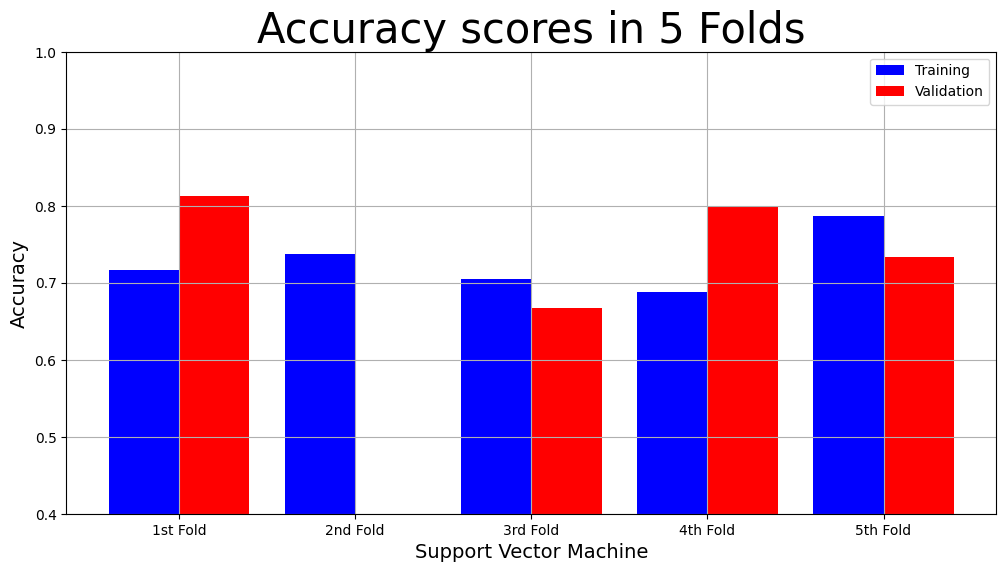

In [69]:
model_name = "Support Vector Machine"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            svm_result["Training Accuracy scores"],
            svm_result["Validation Accuracy scores"])

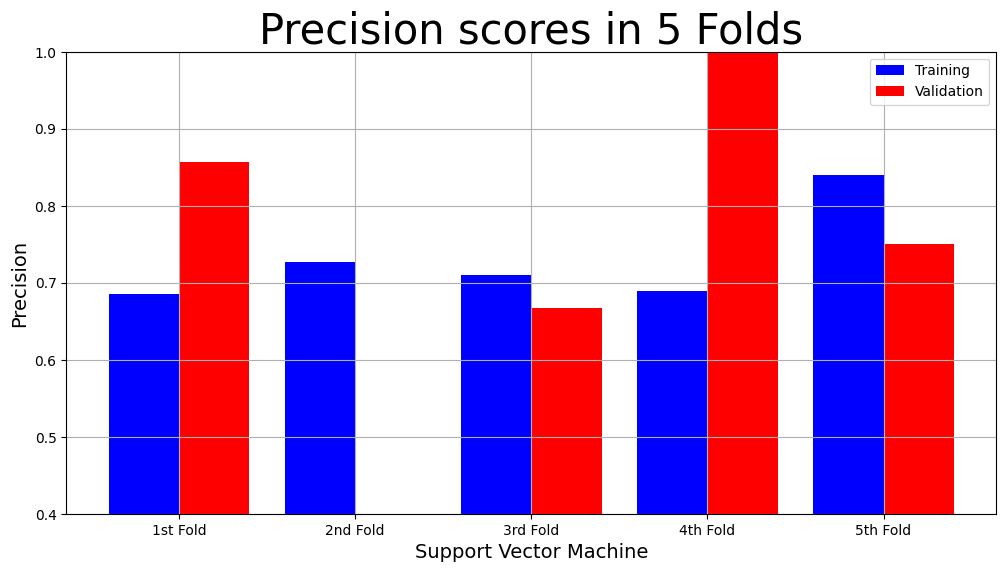

In [70]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            svm_result["Training Precision scores"],
            svm_result["Validation Precision scores"])

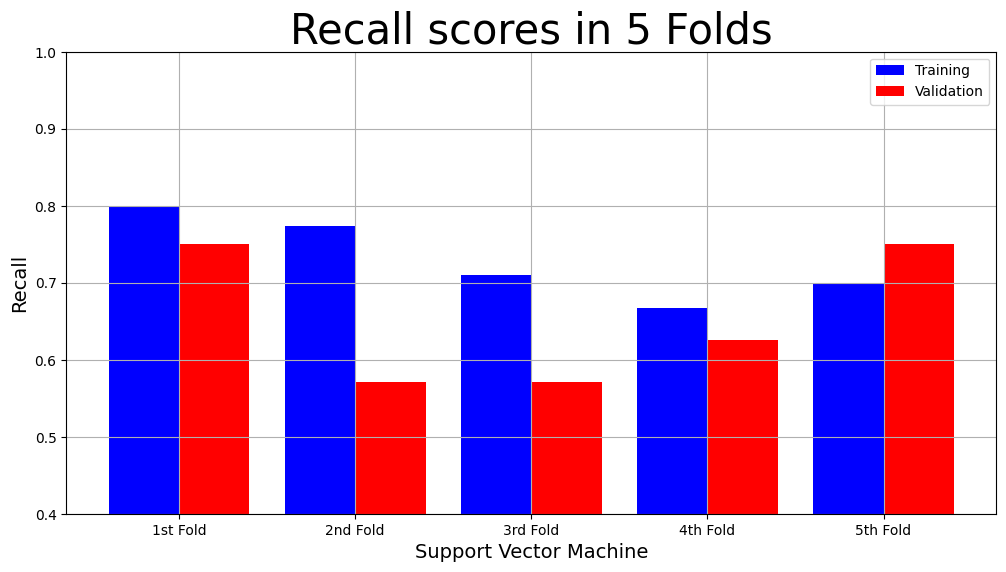

In [71]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            svm_result["Training Recall scores"],
            svm_result["Validation Recall scores"])

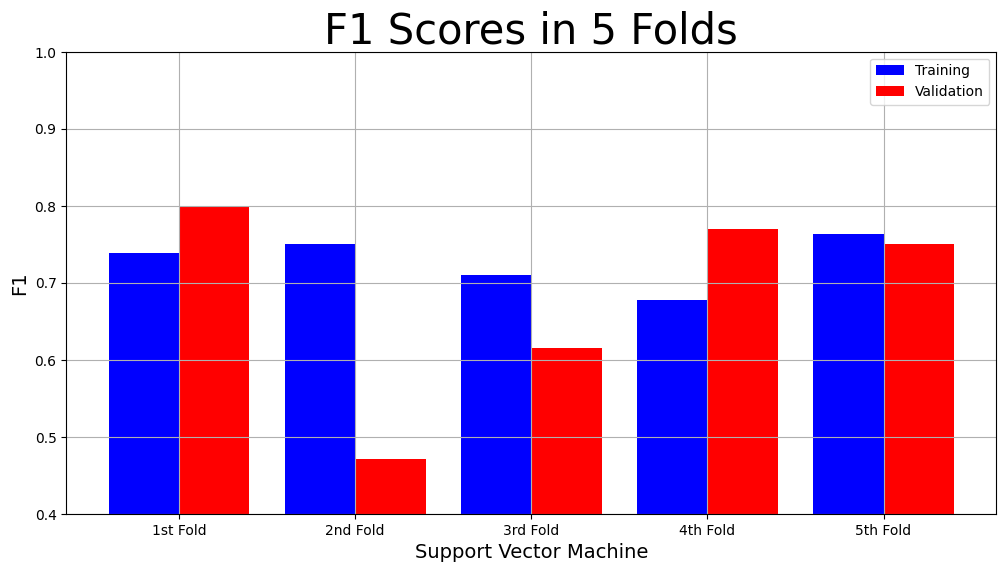

In [72]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            svm_result["Training F1 scores"],
            svm_result["Validation F1 scores"])

### 5. Decision Tree

In [73]:
%%time

from sklearn.tree import DecisionTreeClassifier

#clf = DecisionTreeClassifier(min_samples_split=10,max_depth=3)
#clf.fit(X_scaled, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: "  + str(fit_models['clf'].score(X_test, y_test)))
print("score on train: " + str(fit_models['clf'].score(X_train, y_train)))

train shape: (76, 6)
score on test: 0.8
score on train: 0.8421052631578947
CPU times: total: 0 ns
Wall time: 9.02 ms


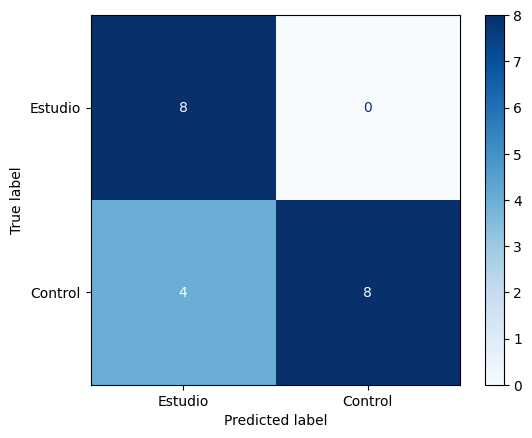

In [74]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['clf'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [75]:
print(classification_report(y_true=y_test,y_pred=fit_models['clf'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       1.00      0.67      0.80        12

    accuracy                           0.80        20
   macro avg       0.83      0.83      0.80        20
weighted avg       0.87      0.80      0.80        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

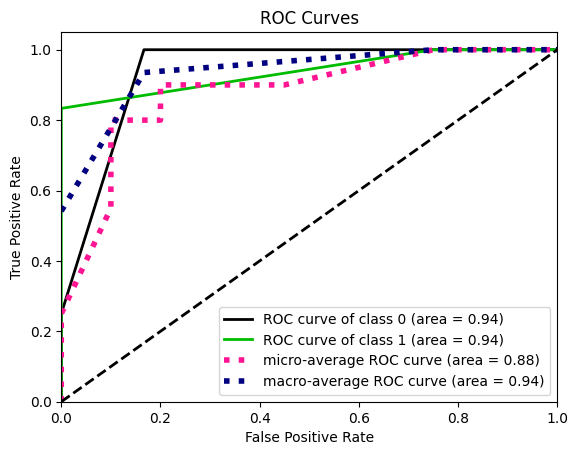

In [76]:
y_predicted = fit_models['clf'].predict_proba(X_test)
plot_roc(y_test, y_predicted)

In [77]:
clf = DecisionTreeClassifier(min_samples_split=10,max_depth=3)
clf_result = cross_validation(clf, X_scaled, y_train, 5)
clf_result

{'Training Accuracy scores': array([0.76666667, 0.91803279, 0.83606557, 0.85245902, 0.83606557]),
 'Mean Training Accuracy': 84.18579234972678,
 'Training Precision scores': array([0.83333333, 0.93333333, 0.81818182, 1.        , 0.95454545]),
 'Mean Training Precision': 0.9078787878787878,
 'Training Recall scores': array([0.66666667, 0.90322581, 0.87096774, 0.7       , 0.7       ]),
 'Mean Training Recall': 0.7681720430107527,
 'Training F1 scores': array([0.74074074, 0.91803279, 0.84375   , 0.82352941, 0.80769231]),
 'Mean Training F1 Score': 0.8267490494165999,
 'Validation Accuracy scores': array([0.6875    , 0.6       , 0.73333333, 0.53333333, 0.46666667]),
 'Mean Validation Accuracy': 60.41666666666667,
 'Validation Precision scores': array([0.8       , 0.55555556, 0.71428571, 0.66666667, 0.5       ]),
 'Mean Validation Precision': 0.6473015873015873,
 'Validation Recall scores': array([0.5       , 0.71428571, 0.71428571, 0.25      , 0.25      ]),
 'Mean Validation Recall': 0.485

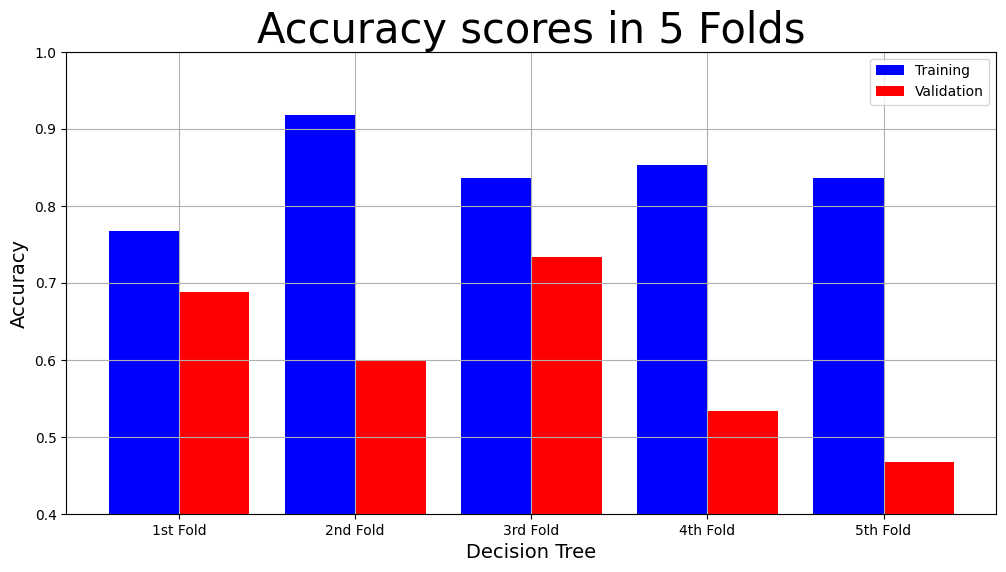

In [78]:
model_name = "Decision Tree"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            clf_result["Training Accuracy scores"],
            clf_result["Validation Accuracy scores"])

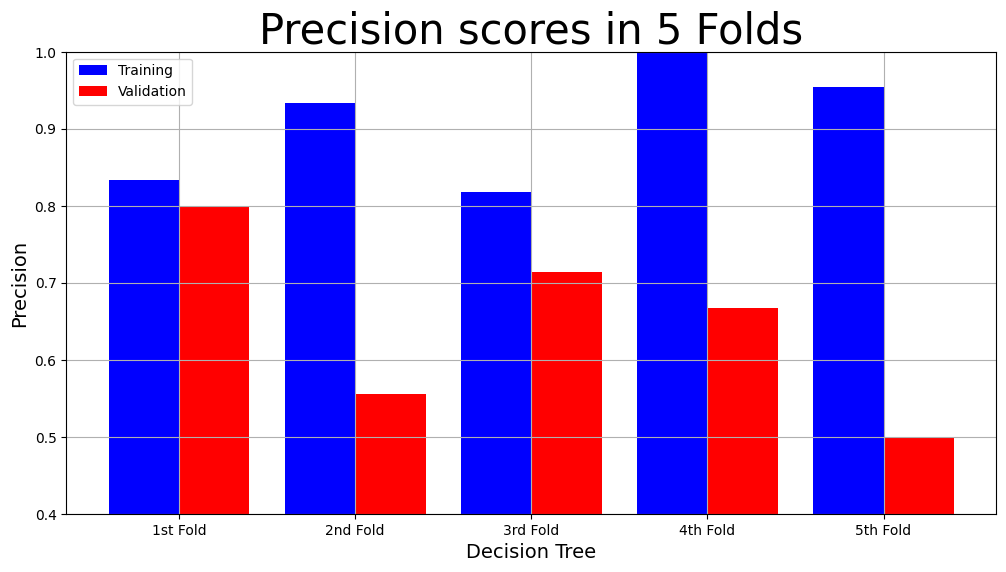

In [79]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            clf_result["Training Precision scores"],
            clf_result["Validation Precision scores"])

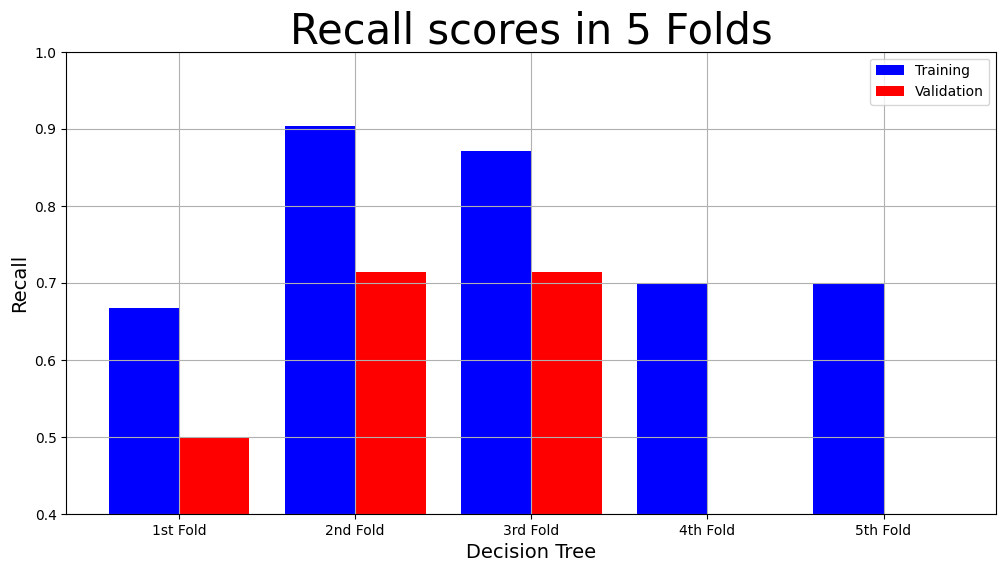

In [80]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            clf_result["Training Recall scores"],
            clf_result["Validation Recall scores"])

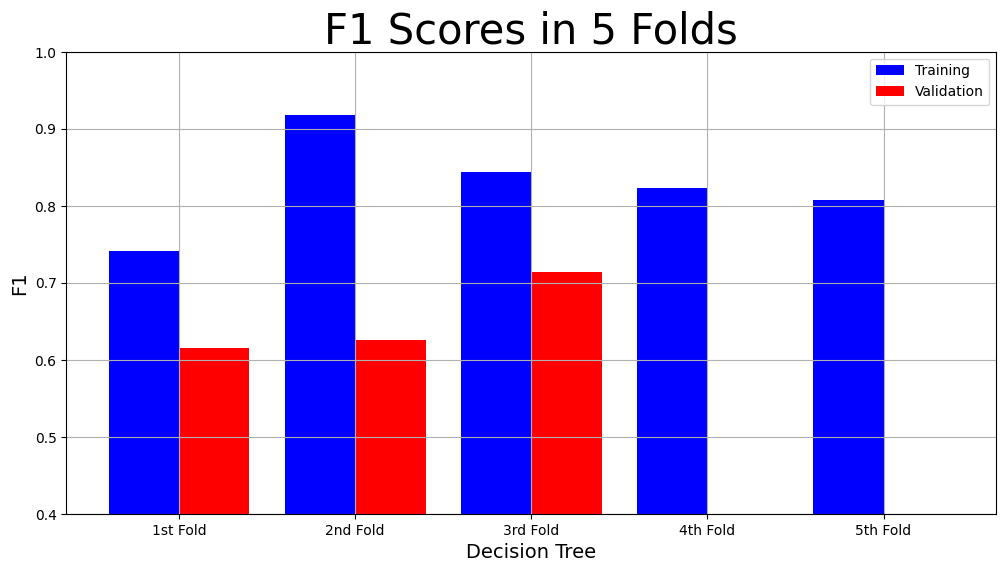

In [81]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            clf_result["Training F1 scores"],
            clf_result["Validation F1 scores"])

### 6. Bagging Decision Tree

In [82]:
%%time

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# x_train_s= X_scaled.tolist()
# x_test_s = X_test_scaled.tolist()

# bg=BaggingClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=3),max_samples=0.5,max_features=1.0,n_estimators=10)
# bg.fit(x_train_s, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['bg'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['bg'].score(X_train, y_train)))

train shape: (76, 6)
score on test: 0.95
score on train: 0.7631578947368421
CPU times: total: 0 ns
Wall time: 15 ms


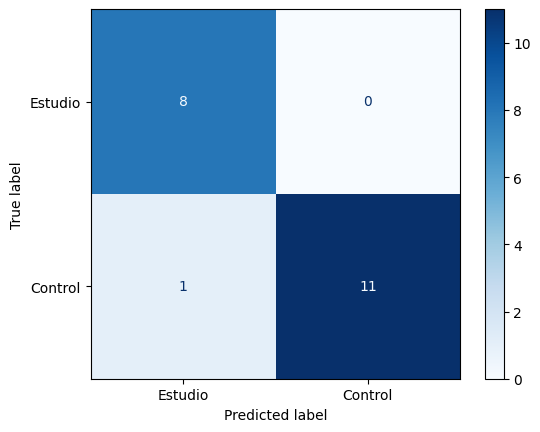

In [83]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['bg'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [84]:
print(classification_report(y_true=y_test,y_pred=fit_models['bg'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.92      0.96        12

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

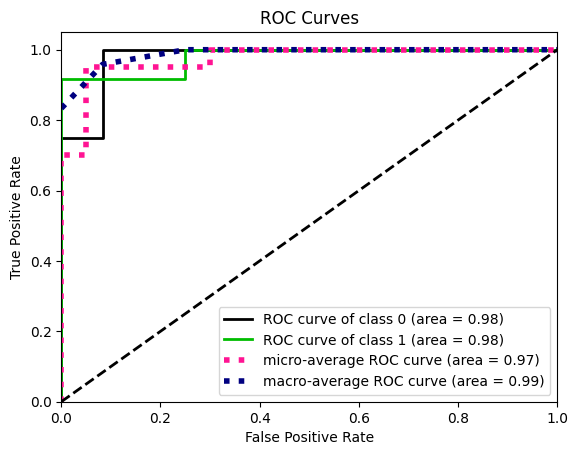

In [85]:
y_predicted = fit_models['bg'].predict_proba(X_test)
plot_roc(y_test, y_predicted)

In [86]:
x_train_s= X_scaled.tolist()
y_= y_train.label.values
bg=BaggingClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=3),max_samples=0.5,max_features=1.0,n_estimators=10)
bg_result = cross_validation(bg, x_train_s, y_train, 5)
bg_result

{'Training Accuracy scores': array([0.78333333, 0.83606557, 0.81967213, 0.81967213, 0.86885246]),
 'Mean Training Accuracy': 82.55191256830601,
 'Training Precision scores': array([0.75757576, 0.92      , 0.83333333, 0.82758621, 0.86666667]),
 'Mean Training Precision': 0.8410323928944619,
 'Training Recall scores': array([0.83333333, 0.74193548, 0.80645161, 0.8       , 0.86666667]),
 'Mean Training Recall': 0.8096774193548388,
 'Training F1 scores': array([0.79365079, 0.82142857, 0.81967213, 0.81355932, 0.86666667]),
 'Mean Training F1 Score': 0.8229954969854942,
 'Validation Accuracy scores': array([0.75, 0.4 , 0.6 , 0.6 , 0.8 ]),
 'Mean Validation Accuracy': 63.000000000000014,
 'Validation Precision scores': array([0.7       , 0.375     , 0.55555556, 0.75      , 0.77777778]),
 'Mean Validation Precision': 0.6316666666666666,
 'Validation Recall scores': array([0.875     , 0.42857143, 0.71428571, 0.375     , 0.875     ]),
 'Mean Validation Recall': 0.6535714285714286,
 'Validation F

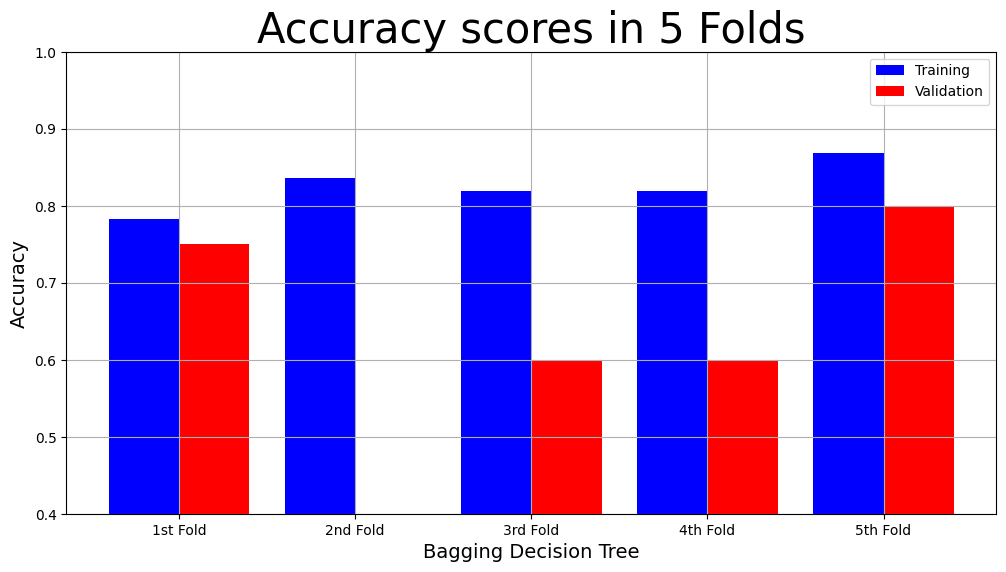

In [87]:
model_name = "Bagging Decision Tree"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            bg_result["Training Accuracy scores"],
            bg_result["Validation Accuracy scores"])

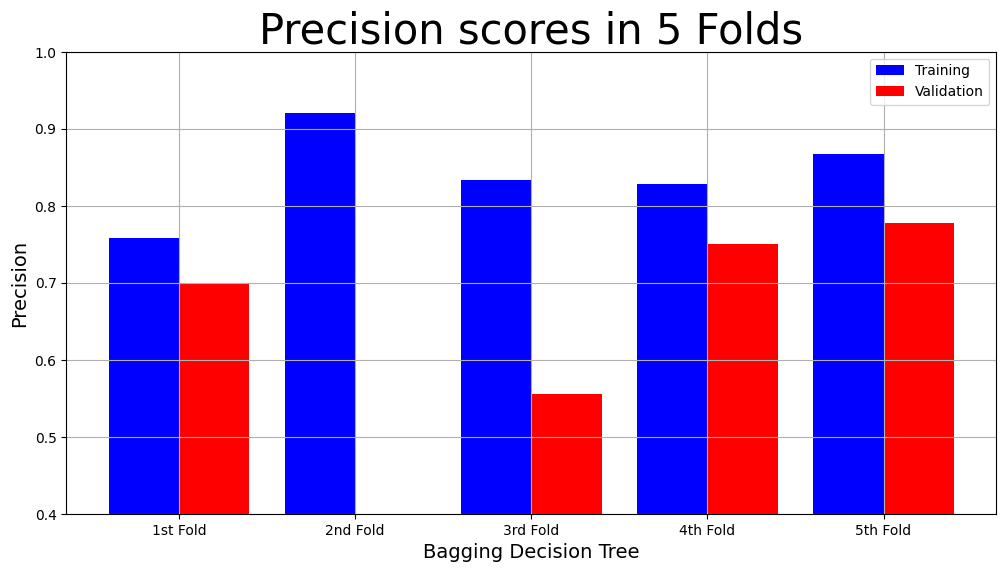

In [88]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            bg_result["Training Precision scores"],
            bg_result["Validation Precision scores"])

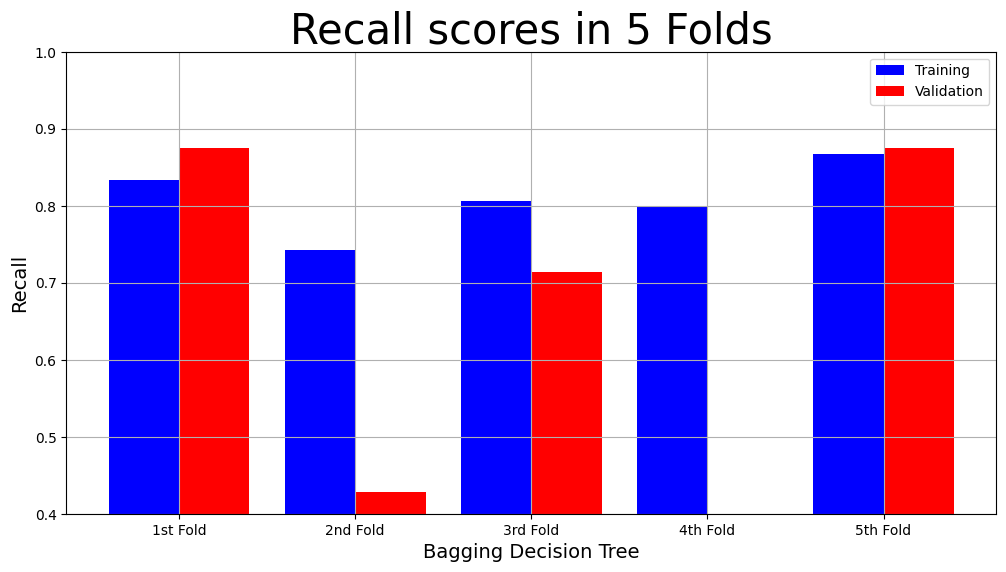

In [89]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            bg_result["Training Recall scores"],
            bg_result["Validation Recall scores"])

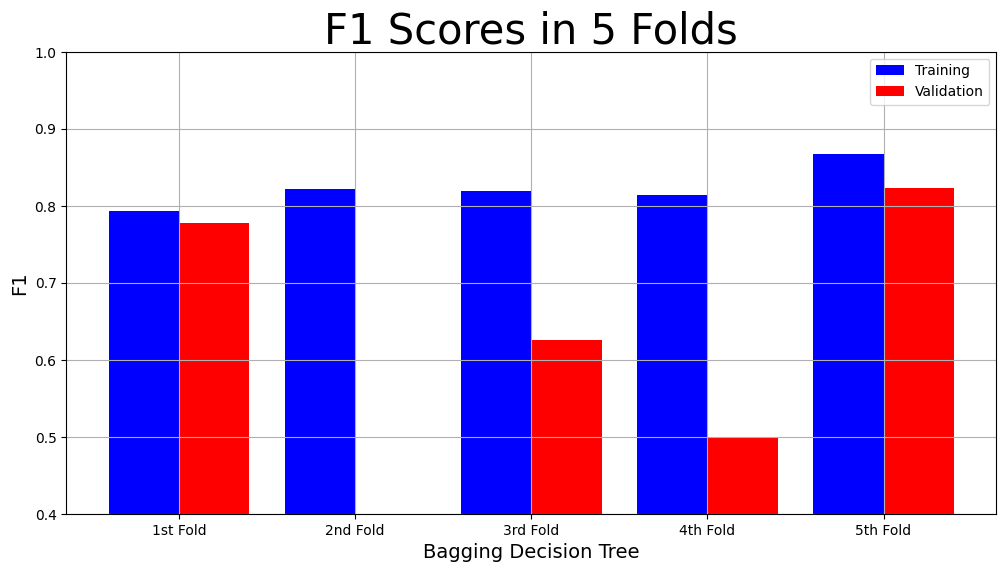

In [90]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            bg_result["Training F1 scores"],
            bg_result["Validation F1 scores"])

### 7. Boosting Decision Tree

In [91]:
%%time

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# setting 
# min_samples_split=10
# max_depth=4

# adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=100,learning_rate=0.5)
# adb.fit(X_scaled, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['adb'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['adb'].score(X_scaled, y_train)))

train shape: (76, 6)
score on test: 0.7
score on train: 0.5
CPU times: total: 0 ns
Wall time: 47.7 ms


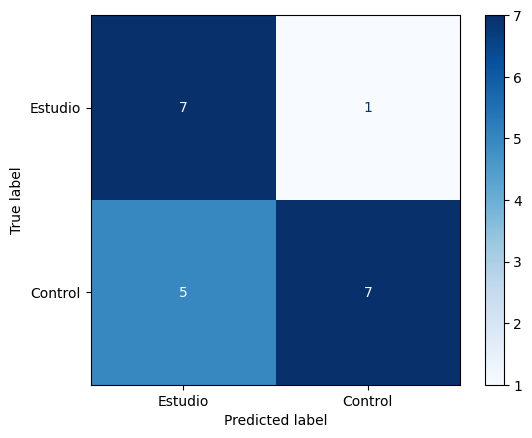

In [92]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['adb'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [93]:
print(classification_report(y_true=y_test,y_pred=fit_models['adb'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.88      0.70         8
           1       0.88      0.58      0.70        12

    accuracy                           0.70        20
   macro avg       0.73      0.73      0.70        20
weighted avg       0.76      0.70      0.70        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

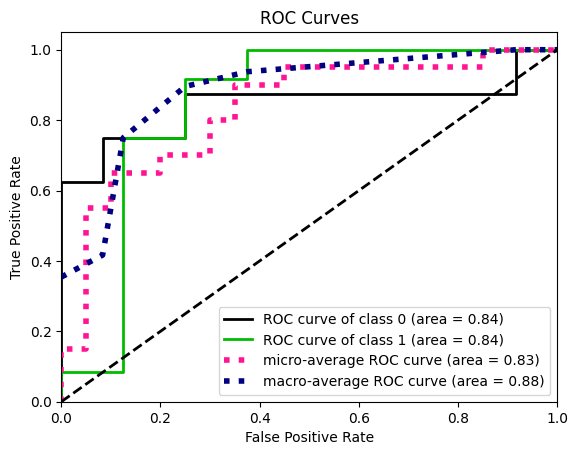

In [94]:
y_predicted = fit_models['adb'].predict_proba(X_test)
plot_roc(y_test, y_predicted)

In [95]:
adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=100,learning_rate=0.5)
adb_result = cross_validation(adb, X_scaled, y_train, 5)
adb_result

{'Training Accuracy scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Accuracy': 100.0,
 'Training Precision scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Precision': 1.0,
 'Training Recall scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Recall': 1.0,
 'Training F1 scores': array([1., 1., 1., 1., 1.]),
 'Mean Training F1 Score': 1.0,
 'Validation Accuracy scores': array([0.4375    , 0.46666667, 0.66666667, 0.73333333, 0.6       ]),
 'Mean Validation Accuracy': 58.08333333333333,
 'Validation Precision scores': array([0.45454545, 0.4       , 0.66666667, 0.75      , 0.75      ]),
 'Mean Validation Precision': 0.6042424242424242,
 'Validation Recall scores': array([0.625     , 0.28571429, 0.57142857, 0.75      , 0.375     ]),
 'Mean Validation Recall': 0.5214285714285715,
 'Validation F1 scores': array([0.52631579, 0.33333333, 0.61538462, 0.75      , 0.5       ]),
 'Mean Validation F1 Score': 0.5450067476383266}

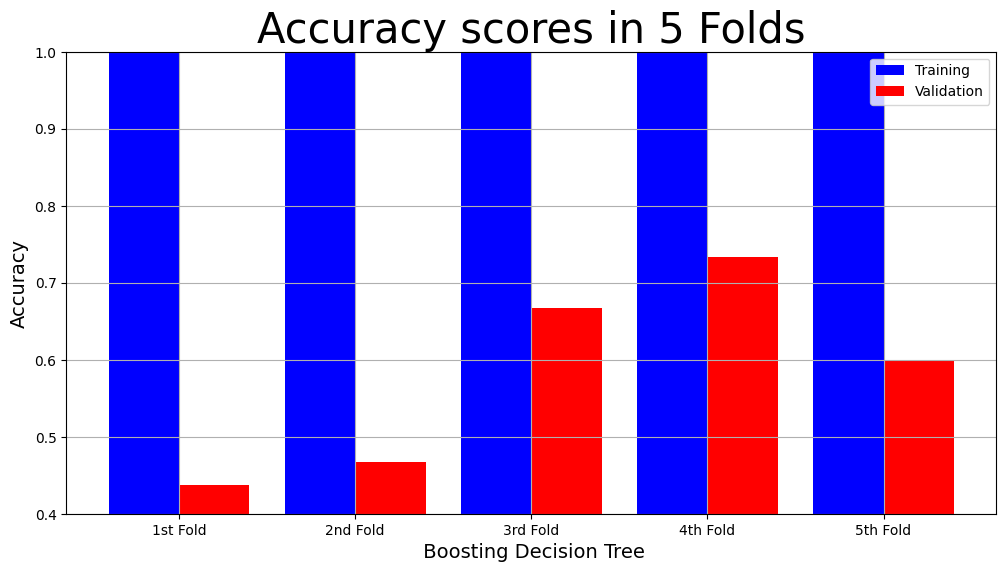

In [96]:
model_name = " Boosting Decision Tree"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            adb_result["Training Accuracy scores"],
            adb_result["Validation Accuracy scores"])

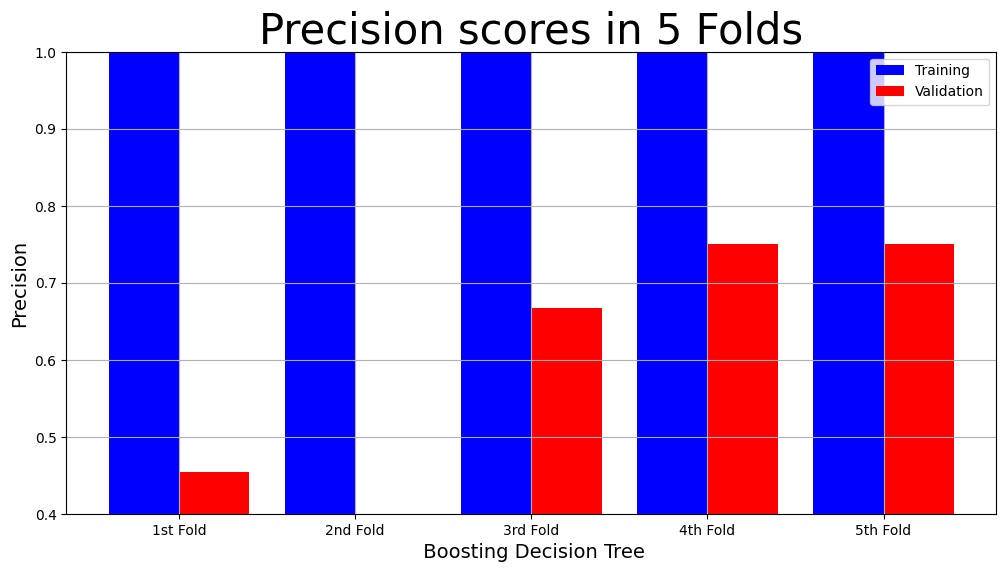

In [97]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            adb_result["Training Precision scores"],
            adb_result["Validation Precision scores"])

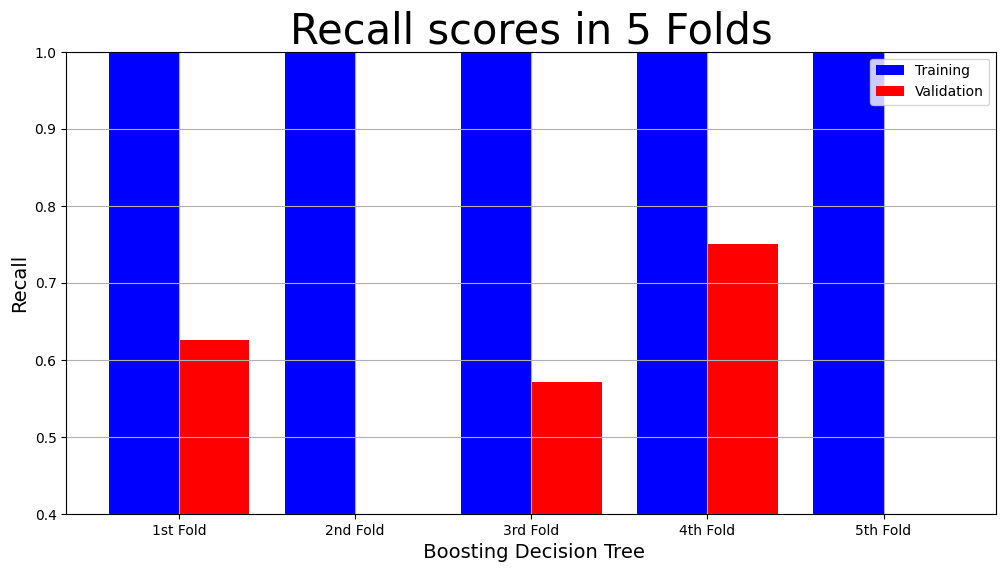

In [98]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            adb_result["Training Recall scores"],
            adb_result["Validation Recall scores"])

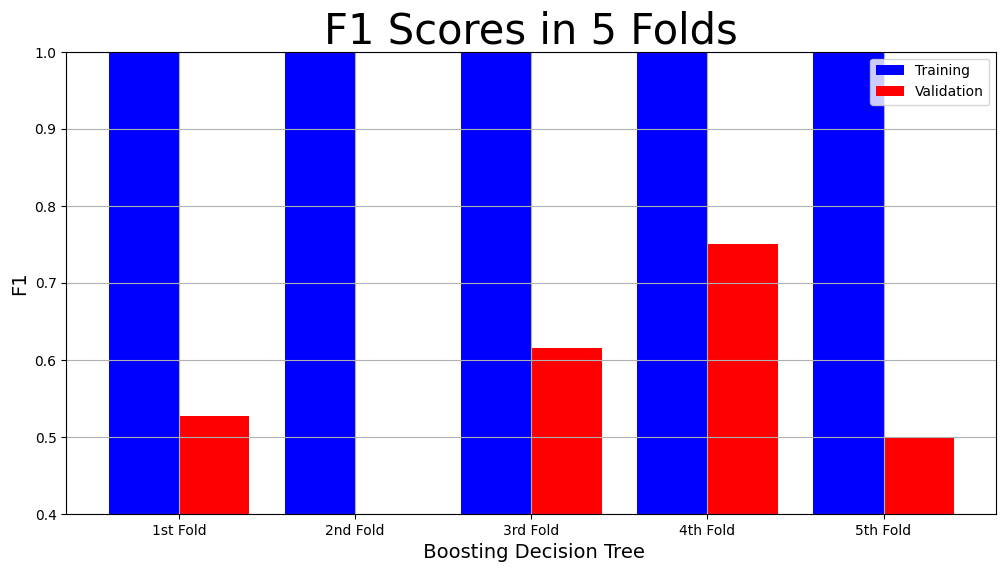

In [99]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            adb_result["Training F1 scores"],
            adb_result["Validation F1 scores"])

### 8. Random Forest

In [100]:
%%time

from sklearn.ensemble import RandomForestClassifier

# n_estimators = number of desission trees
## rf = RandomForestClassifier(n_estimators=300,max_depth=3)
## rf.fit(X_scaled, y_train)

print("score on test: " + str(fit_models['rf'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['rf'].score(X_train, y_train)))

score on test: 0.9
score on train: 0.8947368421052632
CPU times: total: 0 ns
Wall time: 69.3 ms


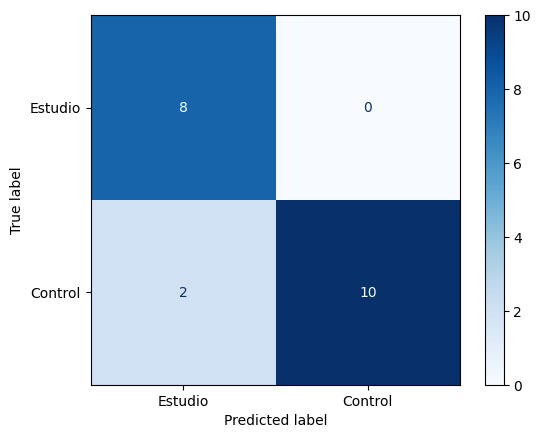

In [101]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['rf'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [102]:
print(classification_report(y_true=y_test,y_pred=fit_models['rf'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.83      0.91        12

    accuracy                           0.90        20
   macro avg       0.90      0.92      0.90        20
weighted avg       0.92      0.90      0.90        20



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

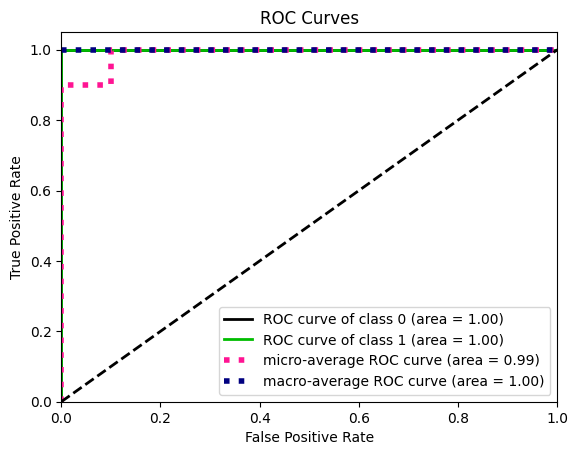

In [103]:
y_predicted = fit_models['rf'].predict_proba(X_test)
plot_roc(y_test, y_predicted)

In [104]:
rf = RandomForestClassifier(n_estimators=300,max_depth=3)
rf_result = cross_validation(rf, X_scaled, y_train, 5)
rf_result

{'Training Accuracy scores': array([0.91666667, 0.93442623, 0.91803279, 0.91803279, 0.93442623]),
 'Mean Training Accuracy': 92.43169398907105,
 'Training Precision scores': array([0.90322581, 0.90909091, 0.90625   , 0.90322581, 0.93333333]),
 'Mean Training Precision': 0.9110251710654937,
 'Training Recall scores': array([0.93333333, 0.96774194, 0.93548387, 0.93333333, 0.93333333]),
 'Mean Training Recall': 0.9406451612903226,
 'Training F1 scores': array([0.91803279, 0.9375    , 0.92063492, 0.91803279, 0.93333333]),
 'Mean Training F1 Score': 0.9255067655477491,
 'Validation Accuracy scores': array([0.8125    , 0.53333333, 0.6       , 0.6       , 0.53333333]),
 'Mean Validation Accuracy': 61.583333333333336,
 'Validation Precision scores': array([0.77777778, 0.5       , 0.55555556, 0.75      , 0.57142857]),
 'Mean Validation Precision': 0.6309523809523808,
 'Validation Recall scores': array([0.875     , 0.57142857, 0.71428571, 0.375     , 0.5       ]),
 'Mean Validation Recall': 0.60

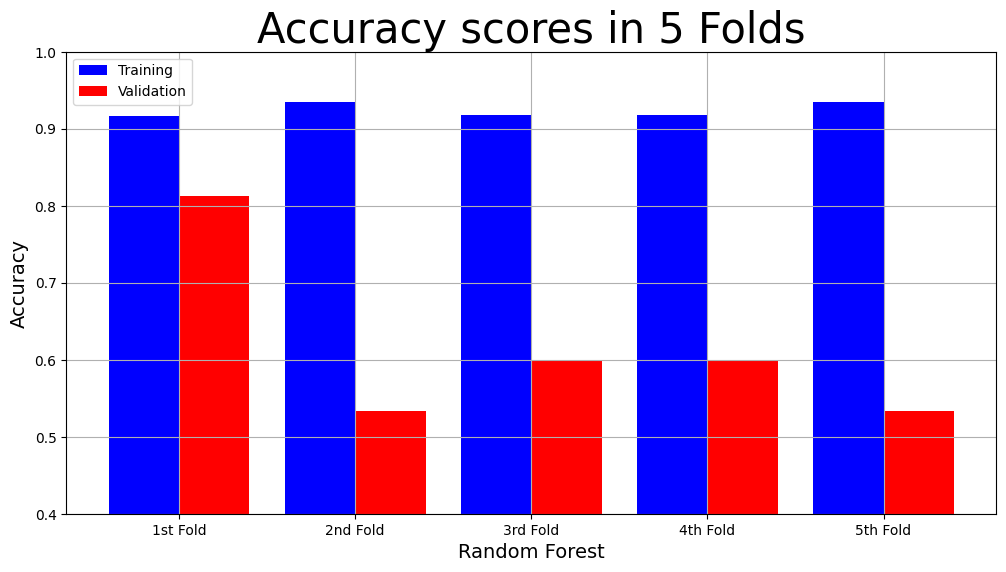

In [105]:
model_name = "Random Forest"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            rf_result["Training Accuracy scores"],
            rf_result["Validation Accuracy scores"])

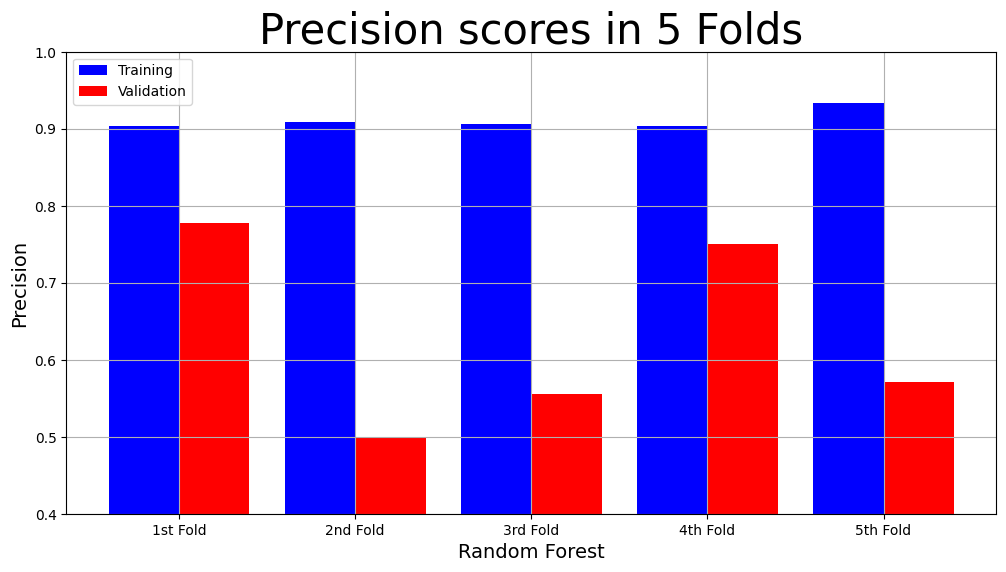

In [106]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            rf_result["Training Precision scores"],
            rf_result["Validation Precision scores"])

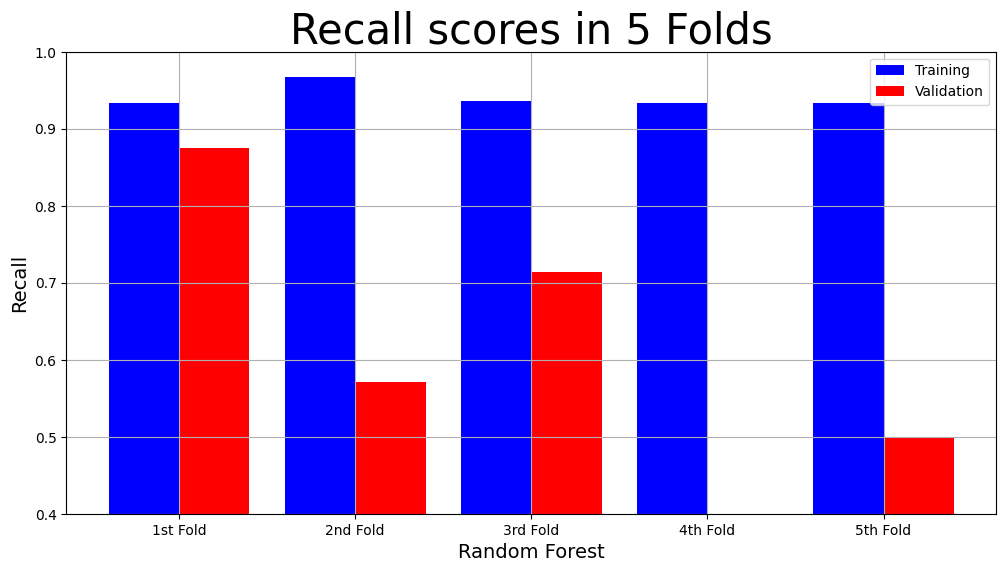

In [107]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            rf_result["Training Recall scores"],
            rf_result["Validation Recall scores"])

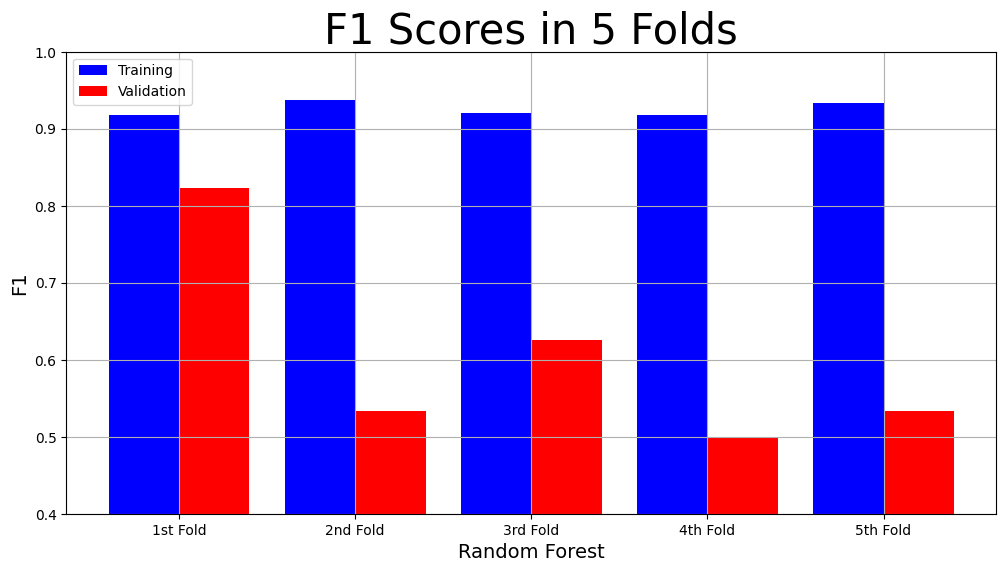

In [108]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            rf_result["Training F1 scores"],
            rf_result["Validation F1 scores"])

### 9. Voting Classifier

In [109]:
%%time

from sklearn.ensemble import VotingClassifier

# 1) naive bias = mnb
#mnb = MultinomialNB().fit(X_norm, y_train)
# 2) logistic regression =lr
#lr=LogisticRegression(max_iter=5000)
# 3) random forest =rf
#rf = RandomForestClassifier(n_estimators=30,max_depth=3)
# 4) suport vecotr mnachine = svm
#svm=LinearSVC(max_iter=5000)


#evc=VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)])
#evc.fit(X_norm, y_train)

print("score on test: " + str(fit_models['evc'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['evc'].score(X_train, y_train)))

score on test: 0.7
score on train: 0.7368421052631579
CPU times: total: 31.2 ms
Wall time: 78.5 ms


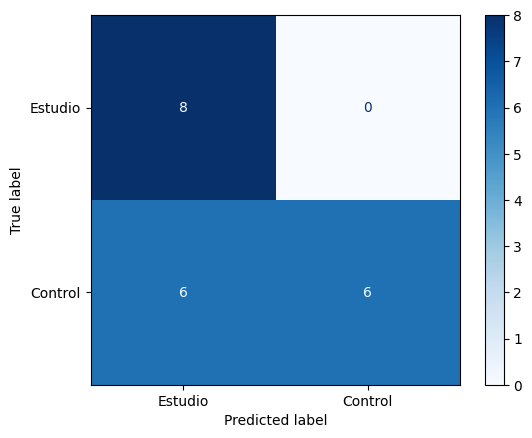

In [110]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['evc'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [111]:
print(classification_report(y_true=y_test,y_pred=fit_models['evc'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73         8
           1       1.00      0.50      0.67        12

    accuracy                           0.70        20
   macro avg       0.79      0.75      0.70        20
weighted avg       0.83      0.70      0.69        20



In [112]:
# 1) naive bias = mnb
mnb = MultinomialNB().fit(X_norm, y_train)
# 2) logistic regression =lr
lr=LogisticRegression(max_iter=5000)
# 3) random forest =rf
rf = RandomForestClassifier(n_estimators=30,max_depth=3)
# 4) suport vecotr mnachine = svm
svm=LinearSVC(max_iter=5000)
evc=VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)])

evc_result = cross_validation(evc, X_norm, y_train, 5)
evc_result

{'Training Accuracy scores': array([0.75      , 0.81967213, 0.75409836, 0.75409836, 0.7704918 ]),
 'Mean Training Accuracy': 76.9672131147541,
 'Training Precision scores': array([0.74193548, 0.8125    , 0.73529412, 0.8       , 0.86363636]),
 'Mean Training Precision': 0.7906731930308781,
 'Training Recall scores': array([0.76666667, 0.83870968, 0.80645161, 0.66666667, 0.63333333]),
 'Mean Training Recall': 0.7423655913978495,
 'Training F1 scores': array([0.75409836, 0.82539683, 0.76923077, 0.72727273, 0.73076923]),
 'Mean Training F1 Score': 0.761353582665058,
 'Validation Accuracy scores': array([0.8125    , 0.46666667, 0.73333333, 0.73333333, 0.6       ]),
 'Mean Validation Accuracy': 66.91666666666667,
 'Validation Precision scores': array([0.85714286, 0.44444444, 0.71428571, 1.        , 0.66666667]),
 'Mean Validation Precision': 0.7365079365079364,
 'Validation Recall scores': array([0.75      , 0.57142857, 0.71428571, 0.5       , 0.5       ]),
 'Mean Validation Recall': 0.60714

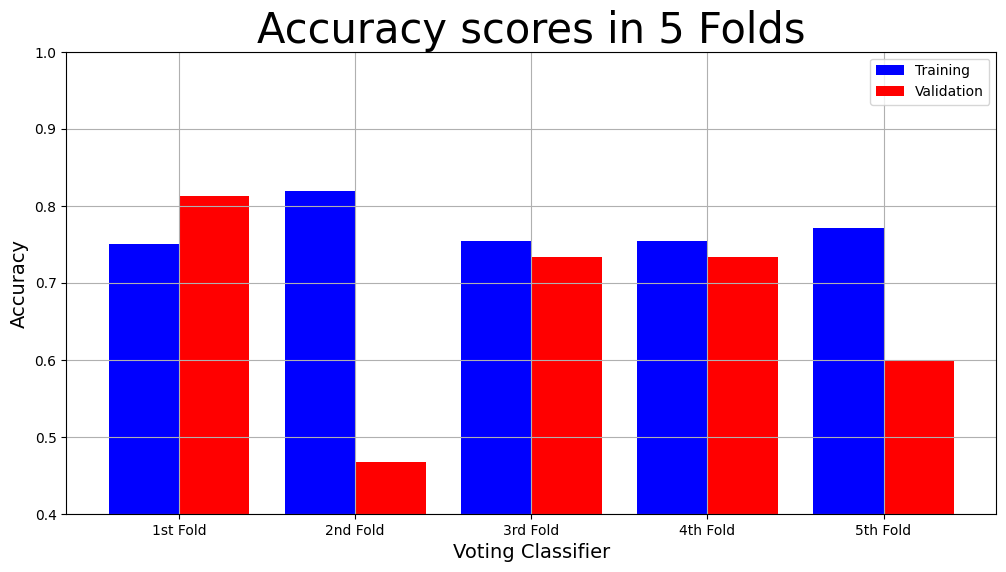

In [113]:
model_name = "Voting Classifier"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            evc_result["Training Accuracy scores"],
            evc_result["Validation Accuracy scores"])

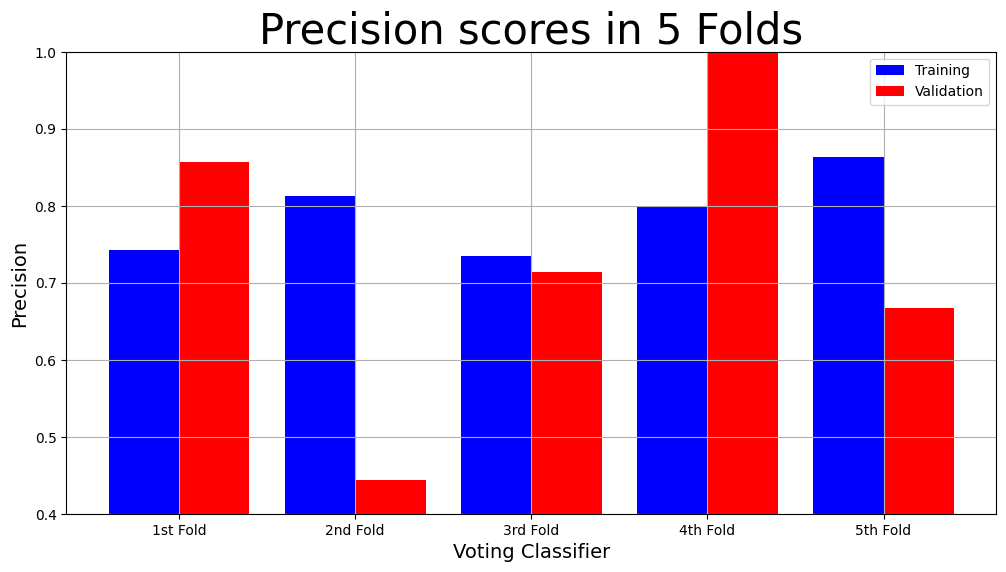

In [114]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            evc_result["Training Precision scores"],
            evc_result["Validation Precision scores"])

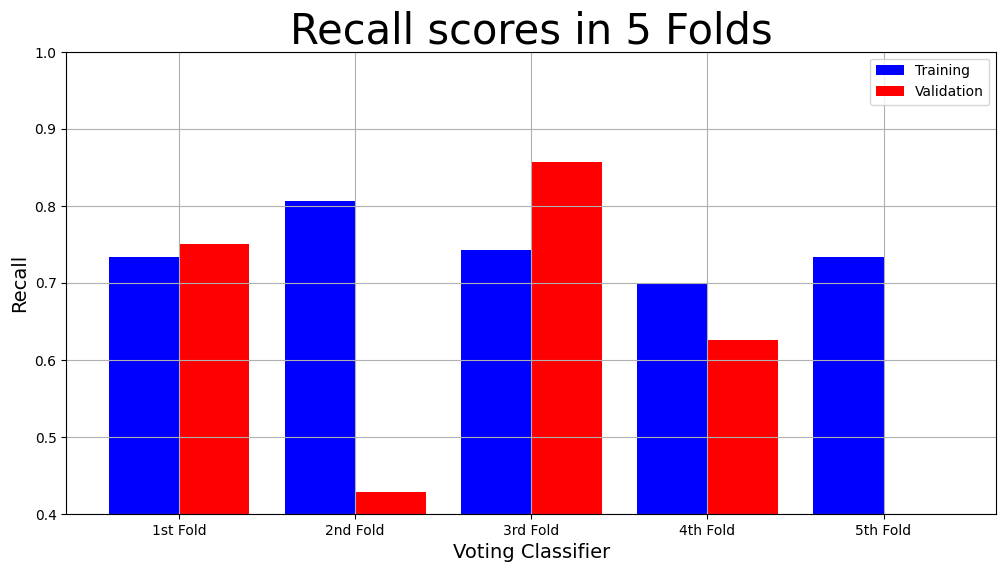

In [115]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            lr_result["Training Recall scores"],
            lr_result["Validation Recall scores"])

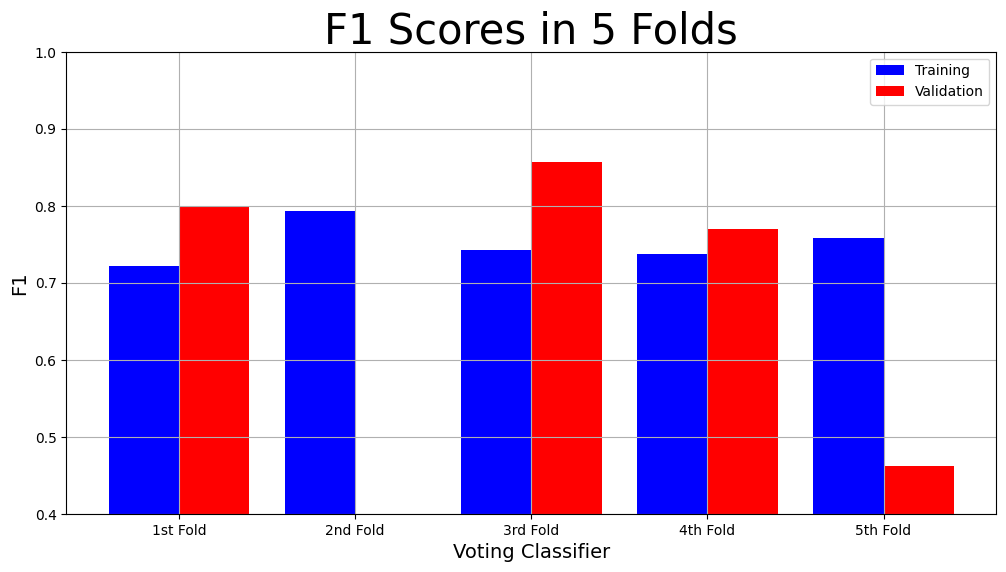

In [116]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            lr_result["Training F1 scores"],
            lr_result["Validation F1 scores"])

### accuray score

In [117]:
%%time
from sklearn.model_selection import cross_val_score

for clf, label in zip([mnb, lr, rf, svm, evc], ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'Support Vector Machine','Ensemble']):
    if label == 'Naive Bayes' or label == 'Ensemble':
        scores = cross_val_score(clf, X_norm, y_train, scoring='accuracy', cv=5)
    else:   
        scores = cross_val_score(clf, X_scaled, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.62 (+/- 0.08) [Naive Bayes]
Accuracy: 0.68 (+/- 0.18) [Logistic Regression]
Accuracy: 0.66 (+/- 0.03) [Random Forest]
Accuracy: 0.68 (+/- 0.18) [Support Vector Machine]
Accuracy: 0.70 (+/- 0.09) [Ensemble]
CPU times: total: 125 ms
Wall time: 514 ms


PROMEDIOS--DE-- mnb
Accuracy 0.723 precision_score 0.752 recall_score 0.723
PROMEDIOS--DE-- svm
Accuracy 0.687 precision_score 0.692 recall_score 0.687
PROMEDIOS--DE-- knn
Accuracy 0.686 precision_score 0.714 recall_score 0.686
PROMEDIOS--DE-- bglr
Accuracy 0.736 precision_score 0.755 recall_score 0.736
PROMEDIOS--DE-- rf 
Accuracy 0.696 precision_score 0.736 recall_score 0.696

#### Modelo stacking 1

In [125]:
# from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import StackingClassifier
#build two layer models using stacking
layer1 = [
    ('svm', make_pipeline(StandardScaler(), LinearSVC(C=0.0001))),
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier(algorithm = 'brute', n_jobs=-1))),
    ('Random Forest', make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=300,max_depth=3))),
    ('bglr', make_pipeline(StandardScaler(), BaggingClassifier(LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True),max_samples=0.5,max_features=1.0,n_estimators=10)))
    ]
layer2 = make_pipeline(MinMaxScaler(), MultinomialNB())

modelStacked = StackingClassifier(
    estimators=layer1,
    final_estimator=layer2) # por defecto cross validation de 5 folds

modelStacked.fit(X_train, y_train)
model_stacked_pred = modelStacked.predict(X_test) 
#see prediction result
print('Accuracy Score: {0:6f}'.format(modelStacked.fit(X_test, y_test).score(X_test, y_test)))

Accuracy Score: 0.600000


In [128]:
print(classification_report(y_true=y_test,y_pred=modelStacked.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.60      1.00      0.75        12

    accuracy                           0.60        20
   macro avg       0.30      0.50      0.37        20
weighted avg       0.36      0.60      0.45        20



#### Modelo stacking 2

In [126]:
# from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import StackingClassifier
#build two layer models using stacking
layer1 = [
    ('svm', make_pipeline(StandardScaler(), LinearSVC(C=0.0001))),
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier(algorithm = 'brute', n_jobs=-1))),
    ('Random Forest', make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=300,max_depth=3))),
    #('bglr', make_pipeline(StandardScaler(), BaggingClassifier(LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True),max_samples=0.5,max_features=1.0,n_estimators=10)))
    ]
layer2 = make_pipeline(StandardScaler(), BaggingClassifier(LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True),max_samples=0.5,max_features=1.0,n_estimators=10))
modelStacked2 = StackingClassifier(
    estimators=layer1,
    final_estimator=layer2) # por defecto cross validation de 5 folds

modelStacked2.fit(X_train, y_train)
model_stacked_pred = modelStacked2.predict(X_test) 
#see prediction result
print('Accuracy Score: {0:6f}'.format(modelStacked2.fit(X_test, y_test).score(X_test, y_test)))

Accuracy Score: 1.000000


In [127]:
print(classification_report(y_true=y_test,y_pred=modelStacked2.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        12

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Stacking Classifier with Cross-Validation

In [133]:
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection


In [189]:
svm = make_pipeline(StandardScaler(), LinearSVC(C=0.0001))
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(algorithm = 'brute', n_jobs=-1))
rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=300,max_depth=3))
bglr = make_pipeline(StandardScaler(), BaggingClassifier(LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True),max_samples=0.5,max_features=1.0,n_estimators=10))
lr = LogisticRegression()
RANDOM_SEED = 42

sclf = StackingCVClassifier(classifiers=[svm, knn, rf, bglr ], 
                           meta_classifier=LogisticRegression(),
                            random_state=RANDOM_SEED)
sclf.fit(X_train, y_train)

StackingCVClassifier(classifiers=[Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('linearsvc',
                                                   LinearSVC(C=0.0001))]),
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('kneighborsclassifier',
                                                   KNeighborsClassifier(algorithm='brute',
                                                                        n_jobs=-1))]),
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('randomforestclassifier',
                                                   RandomForestClassifier(max_depth=3,
                                                                          n_estimators=300))]),
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('baggingclassifier',
                                                   BaggingClassifier(estimator=LogisticRegression(C=0.8,
                                                                                                  class_weight='balanced',
                                                                                                  max_iter=5000,
                                                                                                  solver='newton-cg',
                                                                                                  tol=1e-05,
                                                                                                  warm_start=True),
                                                                     max_samples=0.5))])],
                     meta_classifier=LogisticRegression(), random_state=42)

In [283]:
pipelines = {
    'mnb':make_pipeline(MinMaxScaler(), MultinomialNB()),
    'lr':make_pipeline(StandardScaler(), LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)),
    'knn':make_pipeline(StandardScaler(), KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)),
    'svm':make_pipeline(StandardScaler(), LinearSVC(C=0.0001)),
    'clf':make_pipeline(StandardScaler(), DecisionTreeClassifier(min_samples_split=10,max_depth=3)),
    'bglr':make_pipeline(StandardScaler(), BaggingClassifier(LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True),max_samples=0.5,max_features=1.0,n_estimators=10)),
    'bg':make_pipeline(StandardScaler(), BaggingClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=3),max_samples=0.5,max_features=1.0,n_estimators=10)),
    'adb':make_pipeline(StandardScaler(), AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=100,learning_rate=0.5)),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 100, n_jobs = -1, oob_score = True, bootstrap = True, random_state=42, max_depth=3)),
    'evc':make_pipeline(MinMaxScaler(), VotingClassifier(estimators=[('mnb',MultinomialNB()),('lr', LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)),('rf',RandomForestClassifier(n_estimators=300,max_depth=3)),('svm',LinearSVC(C=0.0001))]))}

model1 = RandomizedSearchCV(pipeline, n_iter=100, verbose=1, cv=3)
model1.fit(X_train, y_train)

TypeError: __init__() missing 1 required positional argument: 'param_distributions'

In [192]:
print('3-fold cross validation:\n')

for clf, label in zip([svm, knn, rf, bglr, sclf], 
                      ['svm', 
                       'knn', 
                       'Random Forest',
                       'bagging logistic regression',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train, y_train, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.68 (+/- 0.08) [svm]
Accuracy: 0.61 (+/- 0.10) [knn]
Accuracy: 0.66 (+/- 0.04) [Random Forest]
Accuracy: 0.74 (+/- 0.06) [bagging logistic regression]
Accuracy: nan (+/- nan) [StackingClassifier]


In [191]:

print("SCLF: ", accuracy_score(y_test, sclf.predict(X_test)))

SCLF:  1.0


In [279]:
import scipy.stats
confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(z_value)

1.959963984540054


In [280]:
# Metodo 1 para calcular el intervalo de confianza por la normal
import numpy as np

fit_models['mnb'].fit(X_train, y_train)

acc_test = fit_models['mnb'].score(X_test, y_test)
ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

ci_lower = acc_test - ci_length
ci_upper = acc_test + ci_length

print(ci_lower, ci_upper)

0.8544831705972787 1.0455168294027213


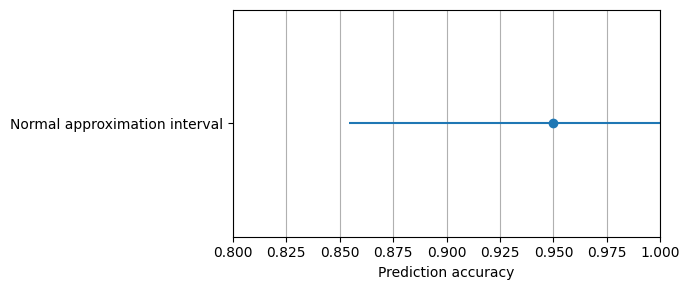

In [281]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 3))

ax.errorbar(acc_test, 0, xerr=ci_length, fmt="o")

ax.set_xlim([0.8, 1.0])

ax.set_yticks(np.arange(1))
ax.set_yticklabels(["Normal approximation interval"])
ax.set_xlabel("Prediction accuracy")

plt.tight_layout()
plt.grid(axis="x")
plt.show()

In [282]:
fit_models['mnb'].fit(X_train, y_train)
y_ = y_test.values
predictions_test = fit_models['mnb'].predict(X_test)
acc_test = np.mean(predictions_test == y_)

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_test.shape[0])

test_accuracies = []

for i in range(200):
    pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    
    acc_test_boot = np.mean(predictions_test[pred_idx] == y_[pred_idx])
    test_accuracies.append(acc_test_boot)

bootstrap_train_mean = np.mean(test_accuracies)
ci_lower = np.percentile(test_accuracies, 2.5)
ci_upper = np.percentile(test_accuracies, 97.5)

print(bootstrap_train_mean, ci_lower, ci_upper)


0.5542 0.49 0.7108750000000001


NameError: name 'bootstrap_train_accuracies' is not defined

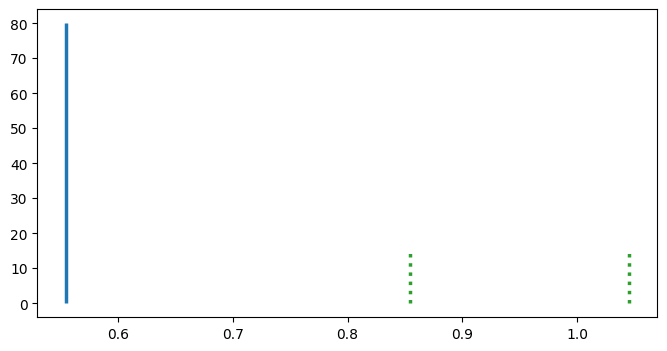

In [278]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.vlines(ci_lower, [0], 15, lw=2.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle="dotted", color="C2")

ax.hist(
    bootstrap_train_accuracies, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)

plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.xlim([0.4, 1.0])

plt.legend(loc="upper left")

plt.grid()
plt.show()

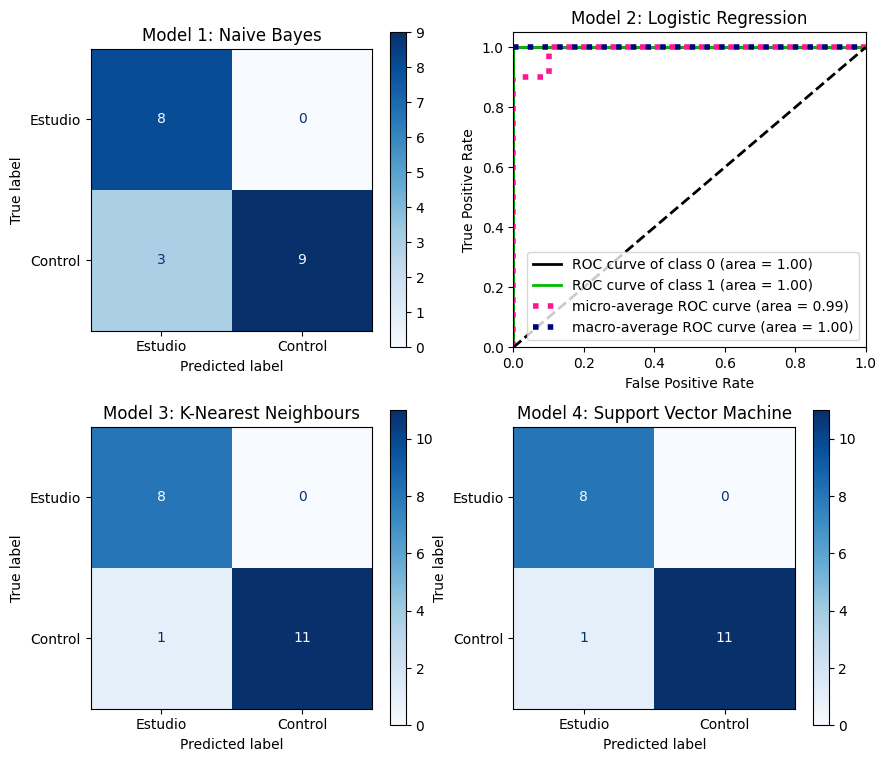

In [221]:
class_names = ['Estudio', 'Control']
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 9))
ConfusionMatrixDisplay.from_estimator(fit_models['mnb'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, ax=ax1, )
plot_roc(y_test, y_predicted, ax=ax2)
ConfusionMatrixDisplay.from_estimator(fit_models['lr'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, ax=ax3)
ConfusionMatrixDisplay.from_estimator(fit_models['knn'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, ax=ax4)
#ConfusionMatrixDisplay.from_estimator(fit_models['svm'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, ax=ax4)
ax1.set_title('Model 1: Naive Bayes')
ax2.set_title('Model 2: Logistic Regression')
ax3.set_title('Model 3: K-Nearest Neighbours')
ax4.set_title('Model 4: Support Vector Machine')
plt.show()


In [229]:
df1.shape

(96, 7)

In [230]:
data = df[[ 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length',
 'sl2l_volume', 'tral_volume']]
data.describe().astype(int)

,ccbd_diameter,sl2l_mean_length,sl2l_diameter,ccbd_mean_length,sl2l_volume,tral_volume
count,96,96,96,96,96,96
mean,27,76,23,120,32162,14393
std,3,6,2,9,6552,5262
min,7,60,15,70,10857,318
25%,25,71,21,115,27928,11815
50%,28,75,22,122,32578,14885
75%,30,80,24,126,37083,17724
max,32,95,29,137,46667,26423


In [235]:
std_scale.fit(data)
scaled_data = pd.DataFrame(std_scale.transform(data),
                           columns=data.columns)

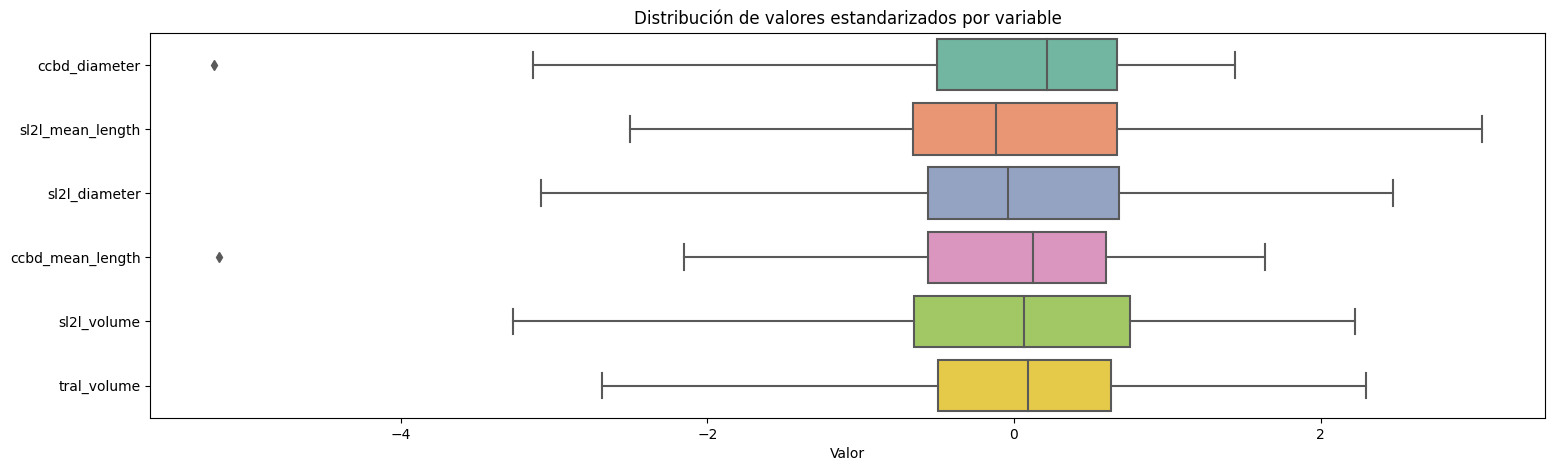

In [236]:
data_boxplot = sns.boxplot(data = scaled_data, orient = "h", palette = "Set2", whis = 3)
plt.title("Distribución de valores estandarizados por variable")
plt.xlabel("Valor")
data_boxplot.figure.set_size_inches(18,5)

In [240]:
from sklearn.ensemble import IsolationForest
import shap
shap.initjs()
seed = 1234
iso_forest = IsolationForest(max_samples = "auto", contamination = "auto", random_state = seed)

In [241]:
iso_forest.fit(data)


IsolationForest(random_state=1234)

In [242]:
outlier_pred = iso_forest.predict(data)
outlier_pred = [False if x == 1 else True for x in outlier_pred]

In [243]:
data[outlier_pred].head()

,ccbd_diameter,sl2l_mean_length,sl2l_diameter,ccbd_mean_length,sl2l_volume,tral_volume
2,26.07,60.09,15.17,109.94,10857.20,17719.00
14,19.18,75.68,21.67,70.16,27908.40,12161.60
31,30.23,80.45,27.18,117.07,46667.40,12700.20
35,21.73,85.55,15.39,99.87,15909.30,8259.21
45,21.75,83.27,16.16,114.15,17083.50,12970.50


In [276]:
fit_models['bglr']
accuracy_score(y_test, fit_models['bglr'].predict(X_test))


0.95

In [ ]:
import matplotlib.pyplot as plt
import math

In [ ]:
w = w1, w2, w3, w4 = fit_models['bglr'].coef_[0]

In [259]:
feature_names = ['ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length',
 'sl2l_volume', 'tral_volume']

In [ ]:
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)